<a href="https://colab.research.google.com/github/alice202122/AI_PROJECT/blob/main/Beat_Classifier_for_ECG_Signals_with_Testing_(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b> BEAT CLASSIFIER FOR ECG SIGNALS

## <b> Giuseppe Di Tursi, B.Eng., Chiara Disanto, B.Eng. and Alice Savino, B.Eng

#CONNECTING TO DRIVE

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
%cd /gdrive/MyDrive/AI_Assignment/

In [ ]:
!unzip training_set.zip

In [4]:
path = '/gdrive/MyDrive/AI_Assignment/'

In [ ]:
input_directory = '/gdrive/MyDrive/AI_Assignment/training_set'

# IMPORTING LIBRARIES

In [ ]:
from scipy.io import loadmat
import pickle
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from numpy import nan
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.feature_selection import VarianceThreshold
from itertools import compress
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.preprocessing import RobustScaler
import random
import numpy as np, os
from numpy import array, matrix, multiply, arange, absolute
from scipy import signal
from scipy import stats
from scipy.signal import lfilter, medfilt, resample, kaiserord, firwin, freqz, correlate
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import ntpath
import matplotlib.pyplot as plt
from matplotlib import pylab as plt
from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show, legend, axis
import copy
!pip install pyhrv
import pyhrv
import pyhrv.time_domain as td
!pip install biosppy
import biosppy
from biosppy.signals import ecg, tools
import math
from math import pi
import seaborn as sns
import re
from keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, Flatten, GlobalAveragePooling1D,  Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout,concatenate, BatchNormalization, Reshape
tf.config.run_functions_eagerly(True)
from sklearn.preprocessing import StandardScaler  # standardize features by removing the mean and scaling to unit variance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
!pip install neurokit2
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 5]
import os
import numpy as np, os, sys, joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile
tfk = tf.keras
from scipy import optimize
from scipy.signal import butter, lfilter, filtfilt
from keras.preprocessing.sequence import pad_sequences
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from keras.models import Model
import random
from scipy.stats import zscore
import numpy as np
import keras.backend as K
K.set_image_data_format('channels_last')
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#SET SEED FOR REPRODUCIBILITY

In [3]:
SEED = 4224
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

#DATA LOADING

We want to adjust the dataset into a matrix to better organize the available data. The matrix structure is the following:

    | ECG (I & II lead) | R peaks location (samples) | Beats annotation ('N', 'S', 'V') |


In [ ]:
def storage(empty_list, input_directory, last_character, name):
  for file in sorted(os.listdir(input_directory)):                                # search among files in input directory
    filename = ntpath.basename(file)                                              # get file name
    filename = os.path.splitext(filename)[0]                                      # remove file extension
    if filename.endswith(last_character):                                         # check filename last character
      mat_file = filename + '.mat'                                                # rejoin extension to filename
      x = loadmat(mat_file)                                                       # load file
      values = np.asarray(x[name])                                                # load values                                
      empty_list.append(values)                                                   # store values in a list
  num_files = len(empty_list)                                                     # checking all files have been stored

  return empty_list, num_files                                                    # return filled list and number of files stored

###ECGs

In [ ]:
ECGs_128 = []                                                                     # ECGs at 128 Hz list initialization

ECGs_128, ECGs128_numfiles = storage(ECGs_128, input_directory, '8', 'ecg')

print('Number of patients (128 Hz): ' +str(ECGs128_numfiles))

Number of patients (128 Hz): 65


In [ ]:
ECGs_250 = []                                                                     # ECGs at 250 Hz list initialization

ECGs_250, ECGs250_numfiles = storage(ECGs_250, input_directory, '0', 'ecg')

print('Number of patients (250 Hz): ' +str(ECGs250_numfiles))

Number of patients (250 Hz): 40


In [ ]:
ECGs = []

for x in ECGs_128:
  ECGs.append(x)
for x in ECGs_250:
  ECGs.append(x)

num_patients = len(ECGs)
print('Number of patients: ' +str(num_patients))

Number of patients: 105


###R PEAKS LOCATION 

In [ ]:
Rpks_128 = []  

Rpks_128, Rpks128_numfiles = storage(Rpks_128, input_directory, '128_rpk', 'rpeaks')

print('Number of patients (128 Hz): ' +str(Rpks128_numfiles))                                       

Number of patients (128 Hz): 65


In [ ]:
Rpks_250 = []  

Rpks_250, Rpks250_numfiles = storage(Rpks_250, input_directory, '250_rpk', 'rpeaks')

print('Number of patients (250 Hz): ' +str(Rpks250_numfiles))    

Number of patients (250 Hz): 40


In [ ]:
Rpks = []

for x in Rpks_128:
  Rpks.append(x)
for x in Rpks_250:
  Rpks.append(x)

num_patients = len(Rpks)
print('Number of patients: ' +str(num_patients))

Number of patients: 105


###BEATS ANNOTATIONS

In [ ]:
anns_128 = []  

anns_128, anns128_numfiles = storage(anns_128, input_directory, '128_ann', 'labels')

print('Number of patients (128 Hz): ' +str(anns128_numfiles))   

Number of patients (128 Hz): 65


In [ ]:
anns_250 = []  

anns_250, anns250_numfiles = storage(anns_250, input_directory, '250_ann', 'labels')

print('Number of patients (250 Hz): ' +str(anns250_numfiles))                                     

Number of patients (250 Hz): 40


In [ ]:
anns = []

for x in anns_128:
  anns.append(x)
for x in anns_250:
  anns.append(x)

num_patients = len(anns)
print('Number of patients: ' +str(num_patients))

Number of patients: 105


###FINAL MATRIX

In [ ]:
data = []   

for patient in range(num_patients):                                               # scrolls patient by patient
  row = [ ECGs[patient], Rpks[patient], anns[patient] ]                        
  data.append(row)                                                                # store row in a list

data = pd.DataFrame(data)
data.to_pickle(path+'data')

In [ ]:
data = pd.read_pickle(path+'data')
data = data.values.tolist()

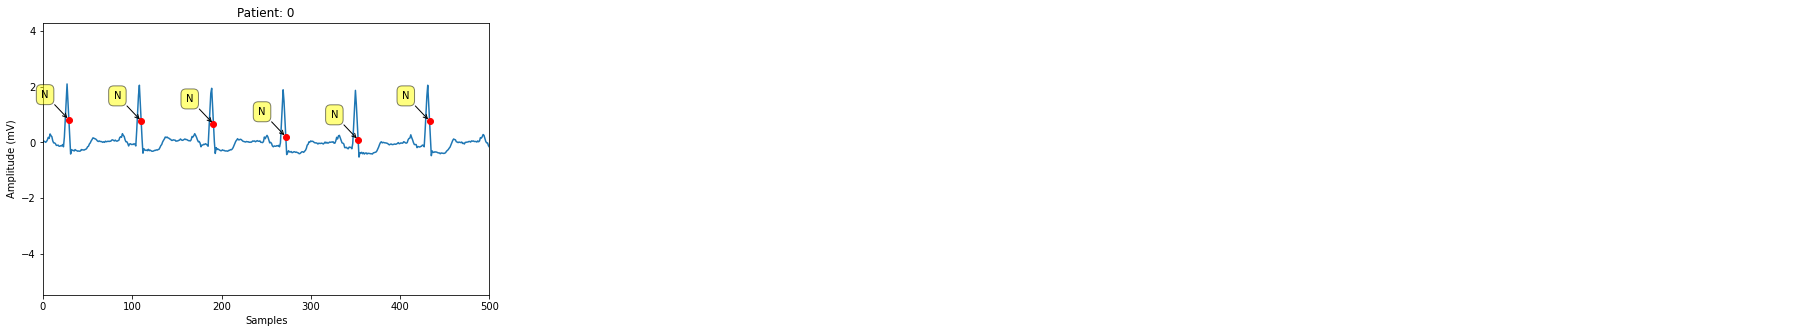

In [ ]:
patient = 0                                  

ECG = 0                                                                           # ECGs are stored in the first column of the data matrix
Ilead = 0                                                                         # I lead is stored in the first column of the ECGs
IIlead = 1                                                                        # II lead is stored in the second column of the ECGs
ECG_I = data[patient][ECG][:,Ilead]                                               
ECG_II = data[patient][ECG][:,IIlead]                                            
Rpk = 1                                                                           # R peaks locations are in the 2nd column of the data matrix
ann = 2                                                                           # annotations are in the 3rd column of the data matrix

plt.title("Patient: " + str(patient))
plt.plot(ECG_I, color='C0')
plt.plot(data[patient][Rpk], ECG_I[data[patient][Rpk]], color='r', marker='o', linestyle='None')
plt.xlabel("Samples")
plt.xlim(0, 500)
plt.ylabel("Amplitude (mV)")

labels = ['{}'.format(i) for i in data[patient][ann]]
for label, x, y in zip(labels, data[patient][Rpk][:25], ECG_I[data[patient][Rpk][:25]]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

#DATA INSPECTION

###SIGNALS LENGTH DISTRIBUTION

Text(0.5, 1.0, 'Signals length distribution')

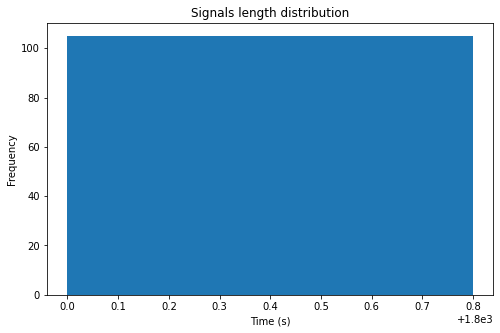

In [ ]:
ECGs_lengths = []                                                                 # ECGs durations list initialization

for i in ECGs_128:                                                                
  ECGs_lengths.append(len(i)/128)                                                 # store 128 Hz signals duration in a list
for i in ECGs_250:                                                                
  ECGs_lengths.append(len(i)/250)                                                 # store 250 Hz signals duration in a list
  
plt.bar(ECGs_lengths, len(ECGs_lengths), align='edge')
plt.xlabel('Time (s)')
plt.ylabel('Frequency')
plt.title("Signals length distribution")

All the signals have the same duration, so the dataset is balanced in these terms.

###TARGET DISTRIBUTION

N:  226932
S:  9609
V:  7795


Text(0.5, 1.0, 'Classes Occurrences')

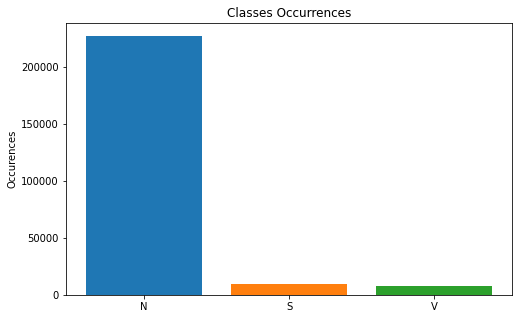

In [ ]:
N = []                                                                            # N annotated beats list initialization      
S = []                                                                            # S annotated beats list initialization              
V = []                                                                            # V annotated beats list initialization  

ann = 2                                                                           # annotations are in the 3rd column of the data matrix

for patient in range(num_patients):                                               # scrolls patient by patient
  for i in data[patient][ann]:          
    if i == 'N':                      
      N.append('N')                                                               # store N annotated beats in a list
    elif i == 'S':                    
      S.append('S')                                                               # store S annotated beats in a list
    elif i == 'V': 
      V.append('V')                                                               # store V annotated beats in a list

print('N: ', len(N))
print('S: ', len(S))
print('V: ', len(V))

plt.bar('N', len(N))
plt.bar('S', len(S))
plt.bar('V', len(V))
plt.ylabel('Occurences')
plt.title('Classes Occurrences')

The label distribution is highly imbalanced. An unbalanced dataset may lead to a biased machine learning (ML) model. Therefore, countermeasures have to be put in place during the model design phase.

#DATA PRE-PROCESSING

###UPSAMPLING

We want to bring all the signals at the same sampling frequency of 250 Hz.
Downsampling to 128 Hz is not recommendable since we would lose informations. Upsampling is the process of interjecting new samples in between existing samples of a signal to increase the sampling rate.  

In [ ]:
def upsampling(ECG_old, fs_old, fs_up):
  deltafs_old = 1/fs_old                                                          # old sampling interval (s)
  duration_old = int(deltafs_old*len(ECG_old))                                    # signal duration (s)
  samples_old = duration_old*fs_old                                               # number of samples with old sampling frequency
  timevec_old = np.linspace(0, duration_old, samples_old, False)                  # old time vector

  deltafs_up = 1/fs_up                                                            # new sampling interval (s)
  samples_up = duration_old*fs_up                                                 # number of samples expected with new sampling frequency
  timevec_up = np.linspace(0, duration_old, samples_up, False)                    # new time vector (same duration as old time vector)

  ECG_up = signal.resample(ECG_old, samples_up)                                   # ECG upsampled using Fourier method. The resampled signal 
                                                                                  # starts at the same value as ECG_old but is sampled with 
                                                                                  # a spacing of len(ECG_old)/samples_up*(spacing of x). 
                                                                                  # Because a Fourier method is used, the signal is assumed 
                                                                                  # to be periodic.

  return timevec_old, timevec_up, ECG_up

####Example for one signal

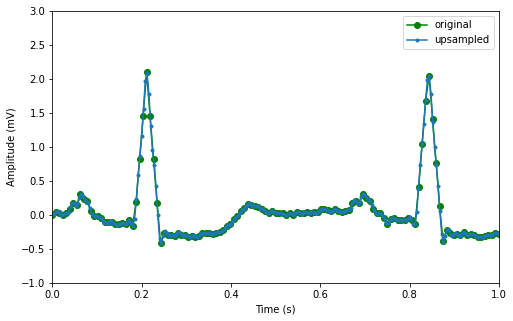

In [ ]:
patient = 0                                  

ECG = 0                                                                           # ECGs are stored in the first column of the data matrix
Ilead = 0                                                                         # I lead is stored in the first column of the ECGs
IIlead = 1                                                                        # II lead is stored in the second column of the ECGs
ECGI_128 = data[patient][ECG][:,Ilead]       
ECGII_128 = data[patient][ECG][:,IIlead]     

time_128, time_250, ECGI128_up = upsampling(ECGI_128, 128, 250)

plt.plot(time_128, ECGI_128, 'go-', time_250, ECGI128_up, '.-')
plt.axis([0, 1, -1, 3])                                         
plt.legend(['original', 'upsampled'], loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.show()

####For all 128 Hz signals

In [ ]:
ECGs128_up = []                                      

ECG = 0                                                                           # ECGs are stored in the first column of the data matrix
Ilead = 0                                                                         # I lead is stored in the first column of the ECGs
IIlead = 1                                                                        # II lead is stored in the second column of the ECGs

for patient in range(ECGs128_numfiles):               
  ECGI_128 = data[patient][ECG][:,Ilead]                    
  ECGI128_up = upsampling(ECGI_128, 128, 250)[2]                                  # I lead at 128 Hz upsampled    
  ECGII_128 = data[patient][ECG][:,IIlead]                
  ECGII128_up = upsampling(ECGII_128, 128, 250)[2]                                # II lead at 128 Hz upsampled
  ECG128_up = [ ECGI128_up, ECGII128_up]
  ECGs128_up.append(ECG128_up)                                                    # store ECGs upsampled in a list

After having upsampled the signals, it is also necessary to adjust the R peaks locations for those signals.

In [ ]:
Rpks128_up = []                                                                   # R peaks new locations list initialization

Rpk = 1                                                                           # R peaks locations are in the 2nd column of the data matrix

for patient in range(Rpks128_numfiles):              
  Rpk128_up = np.round((data[patient][Rpk]/128)*250)                              # R peaks locations with the new sampling frequency
                                                                                  # Rpk_old * 1/fs_old = Rpk_new * 1/fs_new (location in time remains the same)
  Rpks128_up.append(Rpk128_up)                                                    # store new R peaks locations in a list

The same operation is applied also to the 250 Hz signals and R peaks locations in a fictious way in order to have them stored the same way as those upsampled from 128 Hz.

In [ ]:
ECGs250_up = []                                      

ECG = 0                                                                           # ECGs are stored in the first column of the data matrix
Ilead = 0                                                                         # I lead is stored in the first column of the ECGs
IIlead = 1                                                                        # II lead is stored in the second column of the ECGs

for patient in range(ECGs128_numfiles,num_patients):      
  ECGI_250 = data[patient][ECG][:,Ilead]                    
  ECGI250_up = upsampling(ECGI_250, 250, 250)[2]        
  ECGII_250 = data[patient][ECG][:,IIlead]                
  ECGII250_up = upsampling(ECGII_250, 250, 250)[2]   
  ECG250_up = [ ECGI250_up, ECGII250_up]
  ECGs250_up.append(ECG250_up)                       

In [ ]:
Rpks250_up = []    

Rpk = 1                                                                           # R peaks locations are in the 2nd column of the data matrix

for patient in range(Rpks128_numfiles,num_patients):    
  Rpk250_up = np.round((data[patient][Rpk]/250)*250)      
  Rpks250_up.append(Rpk250_up)                       

In [ ]:
ECGs_up = []                                                                      # ECGs upsampled from 128 Hz

for patient in range(ECGs128_numfiles):     
  ECGs_up.append(ECGs128_up[patient])                                             # append the ECGs at 128 Hz
for patient in range(ECGs250_numfiles):     
  ECGs_up.append(ECGs250_up[patient])                                             # append the ECGs at 250 Hz

num_patients = len(ECGs_up)                             
print('Number of patients: ' +str(num_patients))                                         

Number of patients: 105


In [ ]:
Rpks_up = []                                                                      # R peaks locations upsampled from 128 Hz

for patient in range(Rpks128_numfiles):     
  Rpks_up.append(Rpks128_up[patient])                                             # append the R peaks locations at 250 Hz
for patient in range(Rpks250_numfiles):     
  Rpks_up.append(Rpks250_up[patient])                                             # append the R peaks locations at 250 Hz
  
num_patients = len(Rpks_up)                             
print('Number of patients: ' +str(num_patients))                                   

Number of patients: 105


In [ ]:
data_up = []                                                                     

for patient in range(num_patients):                                               # scrolls patient by patient
  row = [ ECGs_up[patient], Rpks_up[patient], anns[patient] ]                    
  data_up.append(row)                                                             # store row in a list

data_up = pd.DataFrame(data_up)
data_up.to_pickle(path+'data_up')

In [ ]:
data_up = pd.read_pickle(path+'data_up')
data_up = data_up.values.tolist()

In [ ]:
fs = 250                                                                          # sampling frequency (Hz)
delta_fs = 1/fs                                                                   # sampling interval (s)

###BASELINE WANDER REMOVAL

We want to detect the baseline and remove it from the overall signals because this usually corresponds to the movement and respiration of the patients, features which are not interested to.

####Example for one signal

Text(0, 0.5, 'Amplitude (mV)')

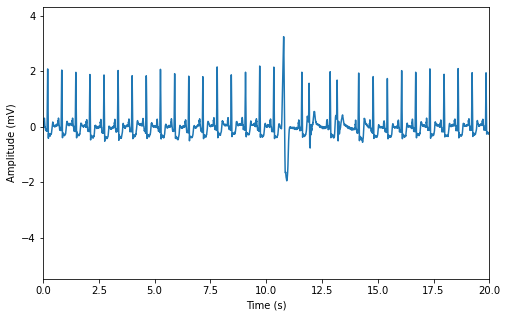

In [ ]:
patient = 0                               

ECG = 0                                                                           # ECGs are stored in the first column of the data matrix
Ilead = 0                                                                         # I lead is stored in the first column of the ECGs
IIlead = 1                                                                        # II lead is stored in the second column of the ECGs
ECGI_up = data_up[patient][ECG][Ilead]          
ECGII_up = data_up[patient][ECG][IIlead]      

duration = int(delta_fs*len(ECGI_up))                                             # signal duration (s)
samples = duration*fs                                                             # number of samples
time_vec = np.linspace(0, duration, samples, endpoint=False)                      # time vector

plot(time_vec, ECGI_up)
xlabel('Time (s)')
plt.xlim(0, 20)
ylabel('Amplitude (mV)')

To detect and eliminate the baseline wander we follow a time domain approach by applying two median filters of different lengths. The foremost idea of the median filter is to track through the signal entry by entry, switching each entry with the median of neighboring entries. The pattern of neighbors is called the "window", which slides, entry by entry, over the entire signal.

######Median Filter (200 ms)

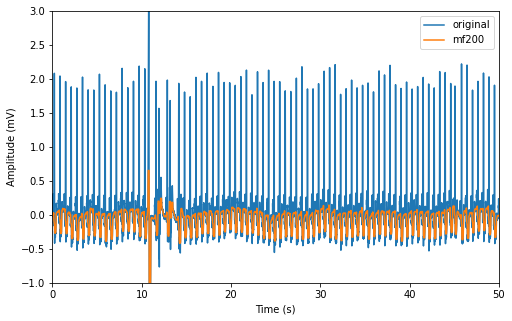

In [ ]:
kernel_t = 0.2                                                                    # kernel duration (s)
kernel_smp = kernel_t*fs                                                          # kernel length (samples)       
ECGIup_mf200 = signal.medfilt(ECGI_up, int(kernel_smp)+1)                         # +1 the one being filtered

plt.plot(time_vec, ECGI_up, time_vec, ECGIup_mf200)
plt.axis([0, 50, -1, 3])
plt.legend(['original', 'mf200'], loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.show()

######Median Filter (600 ms)

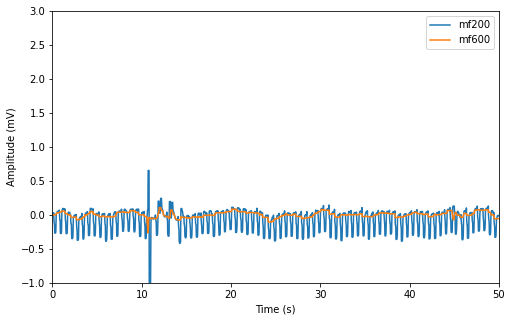

In [ ]:
kernel_t = 0.6                                                                    # kernel duration (s)
kernel_smp = kernel_t*fs                                                          # kernel length (samples)
ECGIup_mf600 = signal.medfilt(ECGIup_mf200, int(kernel_smp)+1)                    # +1 the one being filtered
plt.plot(time_vec, ECGIup_mf200, time_vec, ECGIup_mf600)
plt.axis([0, 50, -1, 3])
plt.legend(['mf200', 'mf600'], loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.show()

######Baseline Removal

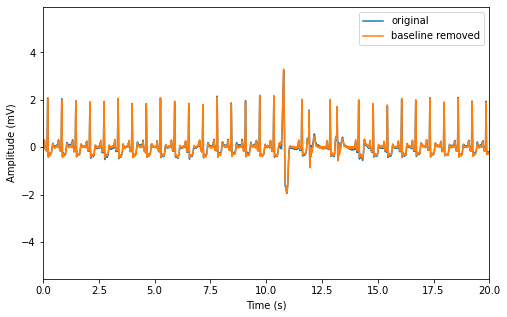

In [ ]:
ECGIup_blr = ECGI_up-ECGIup_mf600

plt.plot(time_vec, ECGI_up, time_vec, ECGIup_blr)
plt.legend(['original', 'baseline removed'], loc='best')
plt.xlabel('Time (s)')
plt.xlim(0, 20)
plt.ylabel('Amplitude (mV)')
plt.show()

The result can be appreciated also in the frequency domain.
By overlapping the power spectrum of the original signal and the one of the manipulated signal in the time domain, the filtering operation is clearly visible since the new spectrum does not show the characteristic baseline peak anymore. Indeed, the baseline contribution usually appears as the highest peak in the spectrum.

In [ ]:
def power_spectrum(data, sampling_rate):
  fourier_transform = np.fft.rfft(data)                                           # FFT computation
  abs_fourier_transform = np.abs(fourier_transform)                               # FFT absolute value
  power_spectrum = np.square(abs_fourier_transform)                               # power spectrum
  frequency = np.linspace(0, sampling_rate/2, len(power_spectrum))                # vector of frequencies

  return frequency, power_spectrum

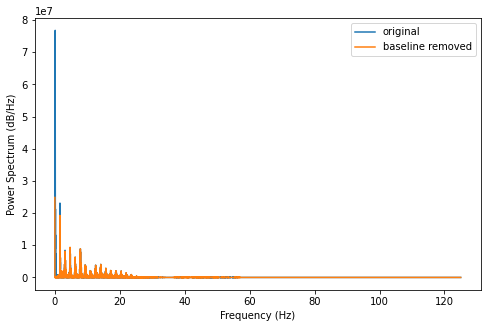

In [ ]:
ECGIup_f, ECGIup_ps = power_spectrum(ECGI_up, fs)
ECGIupblr_f, ECGIupblr_ps = power_spectrum(ECGIup_blr, fs)

plt.plot(ECGIup_f, ECGIup_ps, ECGIupblr_f, ECGIupblr_ps)
plt.legend(['original', 'baseline removed'], loc='best')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectrum (dB/Hz)')
plt.show()

Zooming up in the range 0-1 Hz the removal of the baseline component is clear.

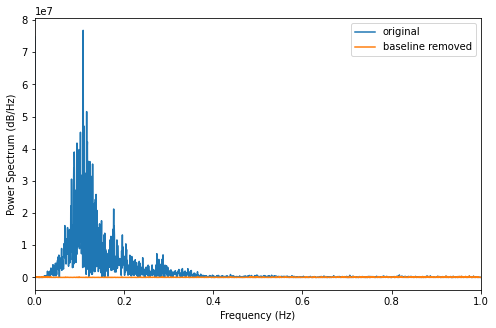

In [ ]:
plt.plot(ECGIup_f, ECGIup_ps, ECGIupblr_f, ECGIupblr_ps)
plt.legend(['original', 'baseline removed'], loc='best')
plt.xlabel('Frequency (Hz)')
plt.xlim(0, 1)
plt.ylabel('Power Spectrum (dB/Hz)')
plt.show()

Then, the baseline wander removal could have been addressed also following a frequency-based approach, so through a high pass filter with cutoff at 0.5 Hz.

####For all signals

In [ ]:
def baseline_filter(patient, lead):
  ECG_up = data_up[patient][ECG][lead]
  kernel_t = 0.2                                                                  # kernel duration (s)
  kernel_smp = kernel_t*fs                                                        # kernel length (samples)          
  ECGup_mf200 = signal.medfilt(ECG_up, int(kernel_smp)+1)                         # +1 the one being filtered
  kernel_t = 0.6                                                                  # kernel duration (s)
  kernel_smp = kernel_t*fs                                                        # kernel length (samples)
  ECGup_mf600 = signal.medfilt(ECGup_mf200, int(kernel_smp)+1)                    # +1 the one being filtered
  ECGup_blr = ECG_up-ECGup_mf600  

  return ECGup_blr

In [ ]:
ECGsup_blr = []              
                         
ECG = 0                                                                           # ECGs are stored in the first column of the data matrix
Ilead = 0                                                                         # I lead is stored in the first column of the ECGs
IIlead = 1                                                                        # II lead is stored in the second column of the ECGs

for patient in range(num_patients):                                               # scrolls patient by patient
  print(patient)
  ECGIup_blr = baseline_filter(patient, Ilead)
  ECGIIup_blr = baseline_filter(patient, IIlead)
  ECGup_blr = [ ECGIup_blr, ECGIIup_blr ]
  ECGsup_blr.append(ECGup_blr)                                                    # store baseline removed signals in a list

In [ ]:
dataup_blr = []                                                                  

for patient in range(num_patients):                                               # scrolls patient by patient
  row = [ ECGsup_blr[patient], Rpks_up[patient], anns[patient] ]                 
  dataup_blr.append(row)                                                          # store row in a list

dataup_blr = pd.DataFrame(dataup_blr)
dataup_blr.to_pickle(path+'dataup_blr')

In [ ]:
dataup_blr = pd.read_pickle(path+'dataup_blr')
dataup_blr = dataup_blr.values.tolist()

###FILTERING

####Example for one signal

Text(0, 0.5, 'Amplitude (mV)')

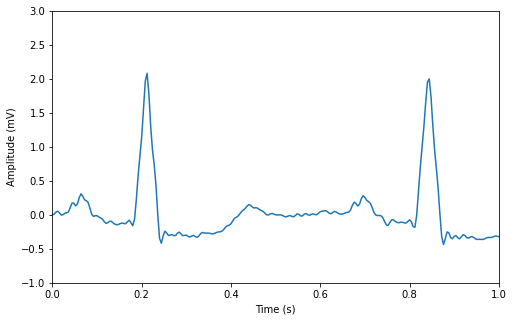

In [ ]:
patient = 0                                        

ECG = 0                                                                           # ECGs are stored in the first column of the data matrix
Ilead = 0                                                                         # I lead is stored in the first column of the ECGs
IIlead = 1                                                                        # II lead is stored in the second column of the ECGs
ECGIup_blr = dataup_blr[patient][ECG][Ilead] 
ECGIiup_blr = dataup_blr[patient][ECG][IIlead]      

duration = int(delta_fs*len(ECGIup_blr))                                          # signal duration (s)
samples = duration*fs                                                             # number of samples
time_vec = np.linspace(0, duration, samples, endpoint=False)                      # time vector

plot(time_vec, ECGIup_blr)
plt.axis([0, 1, -1, 3])
xlabel('Time (s)')
ylabel('Amplitude (mV)')

From this plot it can be noticed the ECG signal needs to be smoothed out.

We apply a low pass filter with 35 Hz cutoff to get rid of the high frequencies responsible of the signal ripples.

In [ ]:
def FIRlowpass(sample_rate, signal, time_axis, cutoff_hz, start, end, figs):

  global delay

  nyq_rate = sample_rate/2.0                                                      # Nyquist frequency
  width = 5.0/nyq_rate                                                            # the desired width of the transition from pass to stop,
                                                                                  # relative to the Nyquist rate. We'll design the filter
                                                                                  # with a 5 Hz transition width.
  ripple_db = 60.0                                                                # the desired attenuation in the stop band, in dB
  N, beta = kaiserord(ripple_db, width)                                           # compute the order and Kaiser parameter for the FIR filter.
  taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))
  filtered = lfilter(taps, 1.0, signal)

  if figs == True:
    
    figure(1)                                                                     # filter coefficients plot
    plot(taps, 'bo-', linewidth=2)
    title('Filter Coefficients (%d taps)' % N)
    grid(True)

    figure(2)                                                                     # filter magnitude response plot
    clf()
    w, h = freqz(taps, worN=8000)
    plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
    xlabel('Frequency (Hz)')
    ylabel('Gain')
    title('Frequency Response')
    ylim(-0.05, 1.05)
    grid(True)
    ax1 = axes([0.42, 0.6, .45, .25])                                             # upper inset plot
    plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
    xlim(0,8.0)
    ylim(0.9985, 1.001)
    grid(True)
    ax2 = axes([0.42, 0.25, .45, .25])                                            # lower inset plot
    plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
    xlim(60.0, 80.0)
    ylim(-0.05, 0.05)
    grid(True)

    delay = 0.5 * (N-1) / sample_rate                                             # the phase delay of the filtered signal

    figure(3)                                                                     # original vs filtered signal plot
    axis([start, end, -1, 3])
    plot(time_axis, signal)
    plot(time_axis, filtered, 'r', linewidth=1)
    legend(['original', 'filtered'], loc='best')
    xlabel('Time (s)')
    ylabel('Amplitude (mV)')
    grid(True)

    figure(4)                                                                     # original vs filtered signal plot (delay corrected)
    axis([start, end, -1, 3])
    plot(time_axis, signal)
    plot(time_axis-delay, filtered, 'r', linewidth=1) 
    title('Delay corrected')
    legend(['original', 'filtered'], loc='best')
    xlabel('Time (s)')
    ylabel('Amplitude (mV)')
    grid(True)

    figure(5)                                                                     # original vs filtered signal frequency spectrum plot
    signal_f, signal_ps = power_spectrum(signal, fs)
    filt_f, filt_ps = power_spectrum(filtered, fs)
    plot(signal_f, signal_ps, filt_f, filt_ps)
    legend(['original', 'filtered'], loc='best')
    xlabel('Frequency (Hz)')
    ylabel('Power Spectrum (dB/Hz)')

    show()
    
  elif figs == False:
    plt.close('all')

  return filtered, delay

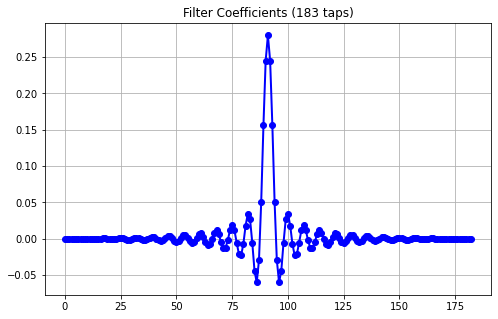

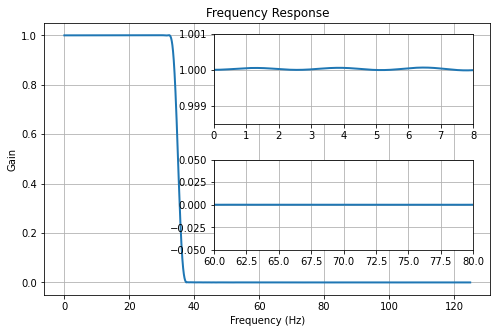

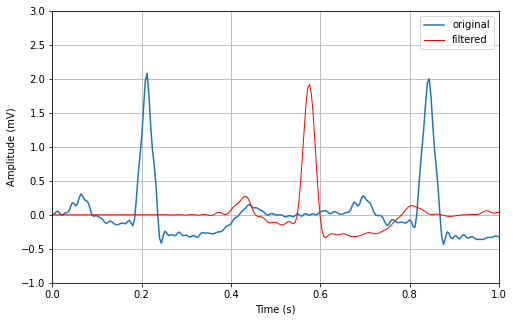

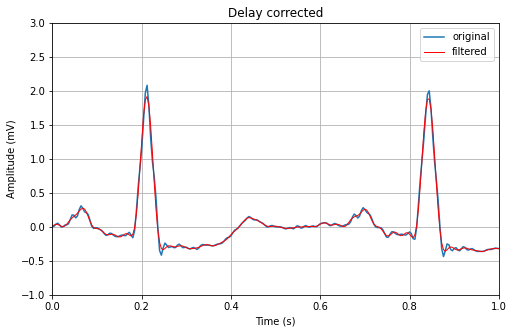

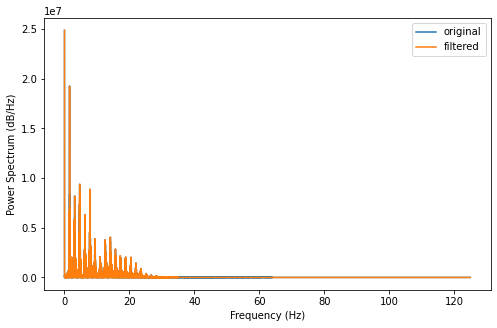

Delay (s): 0.364


In [ ]:
ECGIupblr_filt, delay = FIRlowpass(fs, ECGIup_blr, time_vec, 35, 0, 1, True)

print('Delay (s): ' +str(delay))

####For all signals

In [ ]:
ECGsupblr_filt = []    

ECG = 0                                                                           # ECGs are stored in the first column of the data matrix
Ilead = 0                                                                         # I lead is stored in the first column of the ECGs
IIlead = 1                                                                        # II lead is stored in the second column of the ECGs

for patient in range(num_patients):                                               # scrolls patient by patient
  print(patient)
  ECGIup_blr = dataup_blr[patient][ECG][Ilead]            
  ECGIupblr_filt = FIRlowpass(fs, ECGIup_blr, time_vec, 35, [], [], False)[0]         
  ECGIIup_blr = dataup_blr[patient][ECG][IIlead]            
  ECGIIupblr_filt = FIRlowpass(fs, ECGIIup_blr, time_vec, 35, [], [], False)[0]
  ECGupblr_filt = [ np.pad(ECGIupblr_filt[int(delay*fs):], (0, int(delay*fs)), 'constant'), np.pad(ECGIIupblr_filt[int(delay*fs):], (0, int(delay*fs)), 'constant') ]   # due to the delay caused by the FIR filter, ECGs
                                                                                                                                                                        # samples are taken accordingly and the signals are zero
                                                                                                                                                                        # padded to restore signals original length                                                                                            
  ECGsupblr_filt.append(ECGupblr_filt)

In [ ]:
dataupblr_filt = []                                                              

for patient in range(num_patients):                                               # scrolls patient by patient                                              
  row = [ ECGsupblr_filt[patient], Rpks_up[patient][1:-1], anns[patient][1:-1] ]  # first and last beats, with their respective annotations 
                                                                                  # were discarded for being not complete in some cases           
  dataupblr_filt.append(row)                                                      # store row in a list

dataupblr_filt = pd.DataFrame(dataupblr_filt)
dataupblr_filt.to_pickle(path+'dataupblr_filt')

In [ ]:
dataupblr_filt = pd.read_pickle(path+'dataupblr_filt')
dataupblr_filt = dataupblr_filt.values.tolist()

#BEATS EXTRACTION

Beats are extracted using a fixed window centered around the provided R peaks. Duration of such window as been established based on literature. The idea behind is to identify an approximate estimation of the ECG regions.
Data about each beat are organized as follows:

    || Patient || Beat R peak location (sample) | Beat annotation | Beat time vector (s) | Beat shape - I lead | Beat charact. points locations (samples) - I lead | Beat charact. points on curve - I lead | Beat shape - II lead | Beat charact. points locations (samples) - II lead | Beat charact. points on curve - II lead ||

In [ ]:
wnwst_t = 0.35                                                                    # seconds before the R peak location
wnwend_t = 0.35                                                                   # seconds after the R peak location
wnwst_smp = round(wnwst_t*fs)                                                     # number of samples before the R peak location
wnwend_smp = round(wnwend_t*fs)                                                   # number of samples after the R peak location

The algorithm used to detect the characteristic points on the beat curve may return nan values. These are replaced by an estimation, based on literature, of their position with respect to the beat R peak.

In [ ]:
def points(rpeaks, waves_dwt, n_beat, R):
  Pon = waves_dwt['ECG_P_Onsets'][n_beat]                                         # n_beat P wave onset (sample)
  Pon = np.nan_to_num(Pon, nan=int(R-0.2*fs))
  Pon = Pon.astype(int)
  Ppk = waves_dwt['ECG_P_Peaks'][n_beat]                                          # n_beat P wave peak (sample)
  Ppk = np.nan_to_num(Ppk, nan=int(R-0.162*fs))
  Ppk = Ppk.astype(int)
  Poff = waves_dwt['ECG_P_Offsets'][n_beat]                                       # n_beat P wave offset (sample)      
  Poff = np.nan_to_num(Poff, nan=int(R-0.125*fs))
  Poff = Poff.astype(int)
  Q = waves_dwt['ECG_Q_Peaks'][n_beat]                                            # n_beat Q point (sample)
  Q = np.nan_to_num(Q, nan=int(R-0.05*fs))
  Q = Q.astype(int)
  Ron = waves_dwt['ECG_R_Onsets'][n_beat]                                         # n_beat R peak onset (sample)
  Ron = np.nan_to_num(Ron, nan=int(R-0.02*fs))
  Ron = Ron.astype(int)
  Roff = waves_dwt['ECG_R_Offsets'][n_beat]                                       # n_beat R peak offset (sample)
  Roff = np.nan_to_num(Roff, nan=int(R+0.02*fs))
  Roff = Roff.astype(int)
  S = waves_dwt['ECG_S_Peaks'][n_beat]                                            # n_beat S point (sample)
  S = np.nan_to_num(S, nan=int(R+0.05*fs))
  S = S.astype(int)
  Ton = waves_dwt['ECG_T_Onsets'][n_beat]                                         # n_beat T wave onset (sample)
  Ton = np.nan_to_num(Ton, nan=int(R+0.105*fs))
  Ton = Ton.astype(int)
  Tpk = waves_dwt['ECG_T_Peaks'][n_beat]                                          # n_beat T wave peak (sample)
  Tpk = np.nan_to_num(Tpk, nan=int(R+0.195*fs))
  Tpk = Tpk.astype(int)
  Toff = waves_dwt['ECG_T_Offsets'][n_beat]                                       # n_beat T wave offset (sample)
  Toff = np.nan_to_num(Toff, nan=int(R+0.305*fs))
  Toff = Toff.astype(int)
    
  return Pon, Ppk, Poff, Q, Ron, Roff, S, Ton, Tpk, Toff

In [ ]:
def extractor(wnwst_t, wnwend_t, start, end):
  rows = []                               
  ECG_wnw = []                            
  ECG = 0                                                                         # ECGs are stored in the first column of the data matrix
  Ilead = 0                                                                       # I lead is stored in the first column of the ECGs
  IIlead = 1                                                                      # II lead is stored in the second column of the ECGs
  Rpk = 1                                                                         # R peaks locations are in the 2nd column of the data matrix
  ann = 2                                                                         # annotations are in the 3rd column of the data matrix

  rpk_ex = [nan, nan, nan, nan, nan, nan, nan, nan, nan]

  for patient in range(start, end):                                               # scrolls patient by patient
    print(patient)
    ECGIupblr_filt = dataupblr_filt[patient][ECG][Ilead]
    rpeaks = np.hstack(dataupblr_filt[patient][Rpk])                              # R peaks locations provided together with the dataset
    rpeaks = rpeaks.astype(int)
    _, waves_dwtI = nk.ecg_delineate(ECGIupblr_filt, rpeaks, sampling_rate=250, method="dwt", show=False, show_type='all')
    ECGIIupblr_filt = dataupblr_filt[patient][ECG][IIlead]
    rpeaks = np.hstack(dataupblr_filt[patient][Rpk])                              # R peaks locations provided together with the dataset
    rpeaks = rpeaks.astype(int)
    _, waves_dwtII = nk.ecg_delineate(ECGIIupblr_filt, rpeaks, sampling_rate=250, method="dwt", show=False, show_type='all')
    rows = []
    rows.append(rpk_ex)
    for n_beat, i in enumerate(rpeaks):
      an = dataupblr_filt[patient][ann][n_beat]                                   # n_beat annotation
      R = rpeaks[n_beat]                                                          # n_beat R peak location (sample)
      R_t = R*delta_fs                                                            # n_beat R peak location in time (s)
      time = np.linspace((R_t-wnwst_t), (R_t+wnwend_t), wnwst_smp+wnwend_smp, endpoint=True)    
      PonI, PpkI, PoffI, QI, RonI, RoffI, SI, TonI, TpkI, ToffI = points(rpeaks, waves_dwtI, n_beat, R)
      PonII, PpkII, PoffII, QII, RonII, RoffII, SII, TonII, TpkII, ToffII = points(rpeaks, waves_dwtII, n_beat, R)
      row = [ i, an, time, 
              ECGIupblr_filt[i-wnwst_smp:i+wnwend_smp], 
              [ PonI, PpkI, PoffI, QI, RonI, R, RoffI, SI, TonI, TpkI, ToffI ],
              [ ECGIupblr_filt[PonI], ECGIupblr_filt[PpkI], ECGIupblr_filt[PoffI], ECGIupblr_filt[QI], ECGIupblr_filt[RonI], ECGIupblr_filt[R], ECGIupblr_filt[RoffI], ECGIupblr_filt[SI], ECGIupblr_filt[TonI], ECGIupblr_filt[TpkI], ECGIupblr_filt[ToffI] ],
              ECGIIupblr_filt[i-wnwst_smp:i+wnwend_smp],
              [ PonII, PpkII, PoffII, QII, RonII, R, RoffII, SII, TonII, TpkII, ToffII ],
              [ ECGIIupblr_filt[PonII], ECGIIupblr_filt[PpkII], ECGIIupblr_filt[PoffII], ECGIIupblr_filt[QII], ECGIIupblr_filt[RonII], ECGIIupblr_filt[R], ECGIIupblr_filt[RoffII], ECGIIupblr_filt[SII], ECGIIupblr_filt[TonII], ECGIIupblr_filt[TpkII], ECGIIupblr_filt[ToffII] ] ]
      rows.append(row)
    rows.append(rpk_ex)
    lst = copy.deepcopy(rows)
    perpatient = [ patient, lst ]
    ECG_wnw.append(perpatient)

  return ECG_wnw

For computational reasons, the matrix has been broken down and then eventually reassembled.

In [ ]:
tot_beats1 = extractor(wnwst_t, wnwend_t, 0, 30)
tot_beats1 = pd.DataFrame(tot_beats1)
tot_beats1.to_pickle(path+'tot_beats1')

In [ ]:
tot_beats2 = extractor(wnwst_t, wnwend_t, 30, 60)
tot_beats2 = pd.DataFrame(tot_beats2)
tot_beats2.to_pickle(path+'tot_beats2')

In [ ]:
tot_beats3 = extractor(wnwst_t, wnwend_t, 60, 90)
tot_beats3 = pd.DataFrame(tot_beats3)
tot_beats3.to_pickle(path+'tot_beats3')

In [ ]:
tot_beats4 = extractor(wnwst_t, wnwend_t, 90, 105)
tot_beats4 = pd.DataFrame(tot_beats4)
tot_beats4.to_pickle(path+'tot_beats4')

In [5]:
tot_beats1 = pd.read_pickle(path+'tot_beats1')
tot_beats2 = pd.read_pickle(path+'tot_beats2')
tot_beats3 = pd.read_pickle(path+'tot_beats3')
tot_beats4 = pd.read_pickle(path+'tot_beats4')
tot_beats = pd.concat([tot_beats1, tot_beats2, tot_beats3, tot_beats4], axis=0, ignore_index=True)
tot_beats = tot_beats.values.tolist()

##Example for one beat

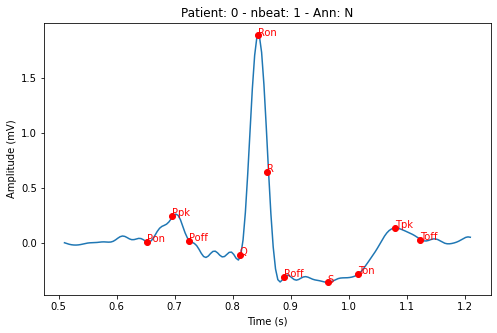

In [ ]:
patient = 0   
n_beat = 1       

column = 1                                                                        # 2nd column of the tot_beats matrix
ann = 1                                                                           # annotations are in the 2nd column of the tot_beats matrix 2nd column
time = 2                                                                          # time vector is in the 3rd column of the tot_beats matrix 2nd column
ECG_Ilead = 3                                                                     # beat shape - I lead is in the 4th column of the tot_beats matrix 2nd column
ECG_IIlead = 6                                                                    # beat shape - II lead is in the 7th column of the tot_beats matrix 2nd column
ECG_lead = 3                                                             
if ECG_lead == ECG_Ilead:                                                       
  k = 0
elif ECG_lead == ECG_IIlead:
  k = 3
pts = 4+k
beat_pts = 5+k

a = tot_beats[patient][column][n_beat][time]
b = tot_beats[patient][column][n_beat][ECG_lead]
c = tot_beats[patient][column][n_beat][pts]
c = [i*delta_fs for i in c]
d = tot_beats[patient][column][n_beat][beat_pts]

labels = ['Pon', 'Ppk', 'Poff', 'Q', 'Ron', 'R', 'Roff', 'S', 'Ton', 'Tpk', 'Toff']
for i, txt in enumerate(labels):
    plt.annotate(txt, (c[i], d[i]), color='r')

plt.plot(a,b) 
plt.plot(c, d, color='r', marker='o', linestyle='None')  
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.title('Patient: ' +str(patient)+ ' - nbeat: ' +str(n_beat)+ ' - Ann: ' +str(tot_beats[patient][column][n_beat][ann]))
show()

#   

#MACHINE LEARNING

##FEATURE EXTRACTION

We are choosing and determining which are the characteristics of the beats that will be influencing our ML model. in particular, for each individual beat, a set of features was computed taking into account the neighboring beats.

###HRV FEATURES


A window of three minutes centered around the current beat is considered for the extraction of the heart rate variability (HRV) features.

In [ ]:
tpltHRVst_t = 90                                                                  # seconds before the R peak location
tpltHRVend_t = 90                                                                 # seconds after the R peak location
tpltHRVst_smp = tpltHRVst_t*fs                                                    # number of samples before the R peak location
tpltHRVend_smp = tpltHRVend_t*fs                                                  # number of samples after the R peak location

In [ ]:
ECG = 0                                                                           # ECGs are stored in the first column of the data matrix
Ilead = 0                                                                         # I lead is stored in the first column of the ECGs
column = 1                                                                        # 2nd column of the tot_beats matrix
beat_rpk = 0                                                                      # beat R peak location is in the 1st column of the tot_beats matrix 2nd column

HRV = []                    
tpltbeatsloc_time = []      

for patient in range(num_patients):                                               # scrolls patient by patient
  print(patient)
  rows = []
  for idxi, i in enumerate(tot_beats[patient][column]):
    if (i[beat_rpk]-tpltHRVst_smp)>0 and (i[beat_rpk]+tpltHRVend_smp)<len(dataupblr_filt[patient][ECG][Ilead]):
      tpltbeatsloc_time = []
      for idkk, k in enumerate(tot_beats[patient][column]):
        if k[beat_rpk]>(i[beat_rpk]-tpltHRVst_smp) and k[beat_rpk]<(i[beat_rpk]+tpltHRVend_smp):
          k_t = k[beat_rpk]/fs                                                    # within the window beats location in time (s)
          tpltbeatsloc_time.append(k_t)
      tpltbeatsloc_time = np.vstack(tpltbeatsloc_time)
      RRs = [j-i for i, j in zip(np.array(tpltbeatsloc_time[:-1]), np.array(tpltbeatsloc_time[1:]))]          # distance of two consecutive R peaks (RR)
      RRs = np.vstack(RRs)
      RRs_mean = np.mean(RRs)                                                      
      RRs_mean = np.median(RRs)
      RRs_median = np.median(RRs)
      RRs_var = np.var(RRs)
      RRs_skew = stats.skew(RRs)
      RRs_std = np.std(RRs)
      RRs_kurt = stats.kurtosis(RRs)
      RMSSD = np.array(pyhrv.time_domain.rmssd(RRs, tpltbeatsloc_time))           # root mean square of successive differences
      dRRs = [j-i for i, j in zip(np.array(RRs[:-1]), np.array(RRs[1:]))]         # difference of consecutive RRs, namely dRRn = RRn+1 − RRn
      dRRs = np.vstack(dRRs)
      dRRs_mean = np.mean(dRRs)
      dRRs_std = np.std(dRRs)
      pNN10 = np.concatenate([i>0.01 for i in dRRs]).sum()*100/len(dRRs)          # percentage of consecutive RRs differences greater than 10
      pNN20 = np.concatenate([i>0.02 for i in dRRs]).sum()*100/len(dRRs)          # percentage of consecutive RRs differences greater than 20
      pNN30 = np.concatenate([i>0.03 for i in dRRs]).sum()*100/len(dRRs)          # percentage of consecutive RRs differences greater than 30
      pNN40 = np.concatenate([i>0.04 for i in dRRs]).sum()*100/len(dRRs)          # percentage of consecutive RRs differences greater than 40
      pNN50 = np.concatenate([i>0.05 for i in dRRs]).sum()*100/len(dRRs)          # percentage of consecutive RRs differences greater than 50
      row = [ i[0], tpltbeatsloc_time, np.round(RRs_mean,4), np.round(RRs_median,4), np.round(RRs_var,4), np.round(RRs_skew,4), np.round(RRs_std,4), np.round(RRs_kurt,4), np.round(RMSSD,4), np.round(dRRs_mean,4), np.round(dRRs_std,4), np.round(pNN10,4), np.round(pNN20,4), np.round(pNN30,4), np.round(pNN40,4), np.round(pNN50,4), i[1] ]
      rows.append(row)
    else:
      row = [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
      rows.append(row)
  lst = copy.deepcopy(rows)
  perpatient = [ patient, lst ]
  HRV.append(perpatient)

HRV = pd.DataFrame(HRV)
HRV.to_pickle(path+'HRV')

In [ ]:
HRV = pd.read_pickle(path+'HRV')
HRV = HRV.values.tolist()

###MORPHOLOGICAL FEATURES

The maximum of cross-correlation function between each detected beat and the following beat is calculated, as well as the maximum of cross-correlation between the current beat and the previous beat detected.
Another feature is the maximum of cross-correlation with respect to a normal beat template. This latter is computed for each patient as the averaged beat of a sequence of many normal sinus beats.

In [ ]:
def corr(ECG_lead, mean, beatpts_lead, pts_lead):
  a = tot_beats[patient][column][idxi][ECG_lead]                                  # current beat                                                              
  b = tot_beats[patient][column][idxi-1][ECG_lead]                                # previous beat
  c = tot_beats[patient][column][idxi+1][ECG_lead]                                # following beat
  lag1_lead = np.argmax(signal.correlate(a, b)) - len(b)                          # lag current beat with respect to the previous one                                                       
  lag2_lead = np.argmax(signal.correlate(a, c)) - len(c)                          # lag current beat with respect to the following one
  lagxy_lead = np.argmax(signal.correlate(a, mean)) - len(mean)                   # lag current beat with respect to the mean one                                                   
  a = (a - np.mean(a)) / (np.std(a) * len(a))
  b = (b - np.mean(b)) / (np.std(b))
  c = (c - np.mean(c)) / (np.std(c))
  corr1_lead = np.correlate(a, b)                                                 # correlation current beat with respect to the previous one
  corr2_lead = np.correlate(a, c)                                                 # correlation current beat with respect to the following one
  corrxy_lead = np.correlate(a, mean)                                             # correlation current beat with respect to the following one
  Ppk_lead = tot_beats[patient][column][idxi][beatpts_lead][Ppk]                  # P wave peak
  Pdur_lead = tot_beats[patient][column][idxi][pts_lead][Poff]*delta_fs-tot_beats[patient][column][idxi][pts_lead][Pon]*delta_fs   # P wave duration                                                    
  Tpk_lead = tot_beats[patient][column][idxi][beatpts_lead][Tpk]                  # T wave peak
  Tdur_lead = tot_beats[patient][column][idxi][pts_lead][Toff]*delta_fs-tot_beats[patient][column][idxi][pts_lead][Ton]*delta_fs   # T wave duration

  return corr1_lead, lag1_lead, corr2_lead, lag2_lead, corrxy_lead, lagxy_lead, Ppk_lead, Pdur_lead, Tpk_lead, Tdur_lead

In [ ]:
ECG = 0                                                                           # ECGs are stored in the first column of the data matrix
Ilead = 0                                                                         # I lead is stored in the first column of the ECGs
IIlead = 1                                                                        # II lead is stored in the second column of the ECGs
column = 1                                                                        # 2nd column of the tot_beats matrix
beat_rpk = 0                                                                      # beat R peak location is stored in the first column
ann = 1                                                                           # annotations are in the 2nd column of the tot_beats matrix 2nd column
ECG_Ilead = 3                                                                     # beat shape - I lead is in the 4th column of the tot_beats matrix 2nd column
ECG_IIlead = 6                                                                    # beat shape - I lead is in the 7th column of the tot_beats matrix 2nd column
pts_Ilead = 4                                                                     # characteristic points locations (samples) - I lead are in the 5th column of the tot_beats matrix 2nd column
pts_IIlead = 7                                                                    # characteristic points locations (samples) - II lead are in the 8th column of the tot_beats matrix 2nd column
beatpts_Ilead = 5                                                                 # characteristic points on curve - I lead are in the 6th column of the tot_beats matrix 2nd column
beatpts_IIlead = 8                                                                # characteristic points on curve - II lead are in the 9th column of the tot_beats matrix 2nd column
Pon = 0                                                                           # P wave onset is in the 1st column of the characteristic points array
Ppk = 1                                                                           # P peak is in the 2st column of the characteristic points array
Poff = 2                                                                          # P wave offset is in the 3rd column of the characteristic points array
Ton = 8                                                                           # T wave onset is in the 9th column of the characteristic points array
Tpk = 9                                                                           # T peak is in the 10th column of the characteristic points array
Toff = 10                                                                         # T wave offset is in the 11th column of the characteristic points array

CORR = []             

sumI = 0
countI = 0
sumII = 0
countII = 0

for patient in range(num_patients):                                                # scrolls patient by patient
  print(patient)
  rows = []
  for idxi, i in enumerate(tot_beats[patient][column]):
    if( i[1] == 'N' ):
      sumI = sumI + i[ECG_Ilead]
      countI = countI + 1
      sumII = sumII + i[ECG_IIlead]
      countII = countII + 1
  meanI = sumI/countI                                                             # mean N beat for I lead
  meanI = (meanI - np.mean(meanI)) / (np.std(meanI)) 
  meanII = sumII/countII                                                          # mean N beat for II lead
  meanII = (meanII - np.mean(meanII)) / (np.std(meanII))
  for idxi, i in enumerate(tot_beats[patient][column]):
    if (i[beat_rpk]-tpltHRVst_smp)>0 and (i[beat_rpk]+tpltHRVend_smp)<len(dataupblr_filt[patient][ECG][Ilead]):
      tplt_loc = [ tot_beats[patient][column][idxi-1][beat_rpk], tot_beats[patient][column][idxi+1][beat_rpk] ]     # previous and following beats
      tplt_ann = [ tot_beats[patient][column][idxi-1][ann], tot_beats[patient][column][idxi+1][ann] ]               # previous and following beats annotations
      corr1_Ilead, lag1_Ilead, corr2_Ilead, lag2_Ilead, corrxy_Ilead, lagxy_Ilead, Ppk_Ilead, Pdur_Ilead, Tpk_Ilead, Tdur_Ilead = corr(ECG_Ilead, meanI, beatpts_Ilead, pts_Ilead) 
      corr1_IIlead, lag1_IIlead, corr2_IIlead, lag2_IIlead, corrxy_IIlead, lagxy_IIlead, Ppk_IIlead, Pdur_IIlead, Tpk_IIlead, Tdur_IIlead = corr(ECG_IIlead, meanII, beatpts_IIlead, pts_IIlead)
      row = [ i[0], tplt_loc, tplt_ann, lag1_Ilead, lag2_Ilead, lagxy_Ilead, lag1_IIlead, lag2_IIlead, lagxy_IIlead, corr1_Ilead, corr2_Ilead, corrxy_Ilead, Ppk_Ilead, Pdur_Ilead, Tpk_Ilead, Tdur_Ilead, corr1_IIlead, corr2_IIlead, corrxy_IIlead, Ppk_IIlead, Pdur_IIlead, Tpk_IIlead, Tdur_IIlead, i[1] ]
      rows.append(row)
    else:
      row = [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
      rows.append(row)
  lst = copy.deepcopy(rows)
  perpatient = [ patient, lst ]
  CORR.append(perpatient)

CORR = pd.DataFrame(CORR)
CORR.to_pickle(path+'CORR')

In [ ]:
CORR = pd.read_pickle(path+'CORR')
CORR = CORR.values.tolist()

######Example for two beats

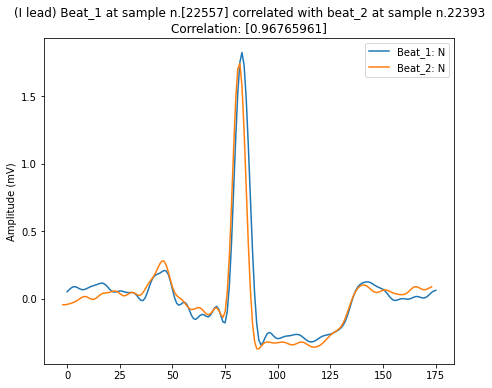

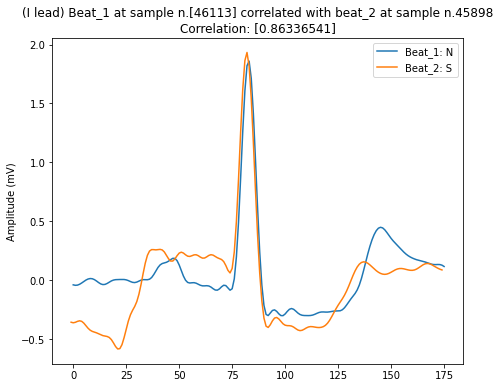

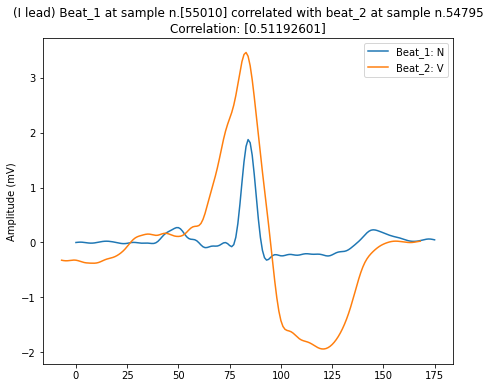

In [ ]:
patient = 0
n = [ 144, 293, 348 ]                                                             

n_beat = 0                                                                        # previous beat=0, next beat=1
column = 1                                                                        # 2nd column of the tot_beats matrix
beat_rpk = 0                                                                      # beat R peak location is stored in the first column  
ann = 1                                                                           # beat annotation is stored in the second column
ECG_lead = 3                                                                      # ECG I_lead=3, ECGII_lead=6
count = 0
tplt_loc = 1
corr1_Ilead = 9
lag1_Ilead = 3
corr2_Ilead = 10
lag2_Ilead = 4
corrxy_Ilead = 11
lagxy_IIlead = 5
corr1_IIlead = 16
lag1_IIlead = 6
corr2_IIlead = 17
lag2_IIlead = 7
corrxy_IIlead = 18
lagxy_IIIlead = 8

for k in n:
  for idx, i in enumerate(tot_beats[patient][column]):
    if (i[beat_rpk] == CORR[patient][column][k][beat_rpk]):
      beat1 = tot_beats[patient][column][idx][ECG_lead]
      time = np.arange(0, len(beat1), 1) 
      idx1 = idx

  for idx, i in enumerate(tot_beats[patient][column]):
    if (i[beat_rpk] == CORR[patient][column][k][tplt_loc][n_beat]):
      beat2 = tot_beats[patient][column][idx][ECG_lead]
      idx2 = idx

  count = count+1
  plt.figure(figsize = (25,6))
  plt.subplot(1,3,count)
  plt.plot(beat1, label = 'Beat_1: %s' %tot_beats[patient][column][idx1][ann])
  if n_beat==0:
    plt.plot(time+CORR[patient][column][k][lag1_Ilead], beat2, label = 'Beat_2: %s' %tot_beats[patient][column][idx2][ann])
    if ECG_lead == 3:
      plt.title('(I lead) Beat_1 at sample n.[' +str(tot_beats[patient][column][idx1][beat_rpk])+ '] correlated with beat_2 at sample n.' +str(tot_beats[patient][column][idx2][beat_rpk])+ '\nCorrelation: ' +str(CORR[patient][column][k][corr1_Ilead]) )
    elif ECG_lead == 6:
      plt.title('(II lead) Beat_1 at sample n.[' +str(tot_beats[patient][column][idx1][beat_rpk])+ '] correlated with beat_2 at sample n.' +str(tot_beats[patient][column][idx2][beat_rpk])+ '\nCorrelation: ' +str(CORR[patient][column][k][corr1_IIlead]) )
  elif n_beat==1:
    plt.plot(time+CORR[patient][column][k][lag2_Ilead], beat2, label = 'Beat_2: %s' %tot_beats[patient][column][idx2][ann])
    if ECG_lead == 3:
      plt.title('(I lead) Beat_1 at sample n.[' +str(tot_beats[patient][column][idx1][beat_rpk])+ '] correlated with beat_2 at sample n.' +str(tot_beats[patient][column][idx2][beat_rpk])+ '\nCorrelation: ' +str(CORR[patient][column][k][corr2_Ilead]) )
    elif ECG_lead == 6:
      plt.title('(II lead) Beat_1 at sample n.[' +str(tot_beats[patient][column][idx1][beat_rpk])+ '] correlated with beat_2 at sample n.' +str(tot_beats[patient][column][idx2][beat_rpk])+ '\nCorrelation: ' +str(CORR[patient][column][k][corr2_IIlead]) )

  plt.legend()
  plt.ylabel('Amplitude (mV)')


###TOTAL FEATURES

The HRV matrix is merged together with CORR matrix in order to obtain the overall feature matrix to feed the machine learning algorithms.

In [ ]:
features_ML = []

for patient in range(num_patients):
  print(patient)
  temp = []
  for i in range(len(HRV[patient][column])):
    a = HRV[patient][column][i][2:-1] 
    b = CORR[patient][column][i][9:]
    c = a+b
    temp.append(c)
  lst = copy.deepcopy(temp)
  perpatient = [ patient, lst ]
  features_ML.append(perpatient)

features_ML = pd.DataFrame(features_ML)
features_ML.to_pickle(path+'features_ML')

In [ ]:
features_ML = pd.read_pickle(path+'features_ML')
features_ML

,0,1
0,0,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
1,1,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2,2,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
3,3,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
4,4,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
...,...,...
100,100,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
101,101,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
102,102,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
103,103,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."


###MISSING DATA HANDLING

In [ ]:
patient = 0
featuresML_pat = pd.DataFrame(features_ML[1].iloc[patient])
featuresML_pat.iloc[142:]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144,0.636,0.636,0.0029,[-0.0191],0.0543,[26.6506],[95.855],-0.0005,0.0960,9.9291,4.6099,3.5461,2.1277,2.1277,[0.9676596143178644],[0.9819444685899703],[0.9373831444972729],0.199473,0.064,0.124375,0.096,[0.956808758938371],[0.960358807015581],[0.86798709870535],0.168707,0.060,0.122189,0.032,N
145,0.636,0.636,0.0031,[-0.1074],0.0553,[24.8559],[95.8994],-0.0006,0.0960,9.9291,4.6099,3.5461,2.1277,2.1277,[0.9819444685899705],[0.9946694527694683],[0.9107649633097012],0.229998,0.072,0.123036,0.100,[0.9603588070155811],[0.9868682748121433],[0.7161308917381001],0.112884,0.064,0.152100,0.052,N
146,0.636,0.636,0.0033,[-0.2334],0.0571,[22.0172],[95.7318],-0.0006,0.0958,9.8940,4.5936,3.5336,2.1201,2.1201,[0.9946694527694682],[0.9432008053289079],[0.9273767511572163],0.225275,0.068,0.107838,0.072,[0.9868682748121433],[0.8799800927296058],[0.7796179353465412],0.134283,0.056,0.102980,0.076,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here all the beats with NaN values are substituted with the values belonging to the first N beat.

In [ ]:
for patient in range(num_patients):
  featureML_pat = pd.DataFrame(features_ML[1].iloc[patient])
  featureML_pat[featureML_pat.isna().any(axis=1)] = featureML_pat[featureML_pat[featureML_pat.columns[-1]] == 'N'].iloc[0]
  featureML_pat = featureML_pat.values.tolist()
  features_ML.at[patient, 1] = featureML_pat

features_ML

,0,1
0,0,"[[0.636, 0.636, 0.0029, -0.0191, 0.0543, 26.65..."
1,1,"[[0.736, 0.736, 0.0071, -2.821, 0.0842, 22.891..."
2,2,"[[0.86, 0.86, 1.7011, 13.4457, 1.3043, 181.196..."
3,3,"[[0.96, 0.96, 0.001, -0.2156, 0.0323, 0.0388, ..."
4,4,"[[0.788, 0.788, 0.0028, -0.5313, 0.0528, 2.192..."
...,...,...
100,100,"[[0.88, 0.88, 0.0016, -1.4973, 0.0396, 2.6037,..."
101,101,"[[0.84, 0.84, 0.0203, 0.3221, 0.1426, 1.1813, ..."
102,102,"[[1.04, 1.04, 0.0043, -0.6481, 0.0654, 0.5579,..."
103,103,"[[1.08, 1.08, 0.0016, -0.6634, 0.0395, 1.3934,..."


In [ ]:
featuresML_all = []
for patient in range(num_patients):
  for i in features_ML.iloc[patient][1]:
    featuresML_all.append(i)

In [ ]:
featuresML_all = pd.DataFrame(featuresML_all, columns=['RRs mean', 'RRs median', 'RRs var', 'RRs skew', 'RRs std', 'RRs kurt', 'RMSSD', 'dRRs_mean', 'dRRs_std', 'pNN10', 'pNN20', 'pNN30', 'pNN40', 'pNN50',
                                                       'Corr1 Ilead', 'Corr2 Ilead', 'Corrxy Ilead', 'Ppk Ilead (mV)', 'Pdur Ilead (s)', 'Tpk Ilead (mV)', 'Tdur Ilead (s)', 'Corr1 IIlead', 'Corr2 IIlead', 'Corrxy IIlead', 'Ppk IIlead (mV)', 'Pdur IIlead (s)', 'Tpk IIlead (mV)', 'Tdur IIlead (s)', 'Target'])
featuresML_all.to_csv(path+'featuresML_all.csv')

In [ ]:
featuresML_all

,RRs mean,RRs median,RRs var,RRs skew,RRs std,RRs kurt,RMSSD,dRRs_mean,dRRs_std,pNN10,pNN20,pNN30,pNN40,pNN50,Corr1 Ilead,Corr2 Ilead,Corrxy Ilead,Ppk Ilead (mV),Pdur Ilead (s),Tpk Ilead (mV),Tdur Ilead (s),Corr1 IIlead,Corr2 IIlead,Corrxy IIlead,Ppk IIlead (mV),Pdur IIlead (s),Tpk IIlead (mV),Tdur IIlead (s),Target
0,0.636,0.636,0.0029,-0.0191,0.0543,26.6506,95.855,-0.0005,0.0960,9.9291,4.6099,3.5461,2.1277,2.1277,0.96766,0.981944,0.937383,0.199473,0.064,0.124375,0.096,0.956809,0.960359,0.867987,0.168707,0.060,0.122189,0.032,N
1,0.636,0.636,0.0029,-0.0191,0.0543,26.6506,95.855,-0.0005,0.0960,9.9291,4.6099,3.5461,2.1277,2.1277,0.96766,0.981944,0.937383,0.199473,0.064,0.124375,0.096,0.956809,0.960359,0.867987,0.168707,0.060,0.122189,0.032,N
2,0.636,0.636,0.0029,-0.0191,0.0543,26.6506,95.855,-0.0005,0.0960,9.9291,4.6099,3.5461,2.1277,2.1277,0.96766,0.981944,0.937383,0.199473,0.064,0.124375,0.096,0.956809,0.960359,0.867987,0.168707,0.060,0.122189,0.032,N
3,0.636,0.636,0.0029,-0.0191,0.0543,26.6506,95.855,-0.0005,0.0960,9.9291,4.6099,3.5461,2.1277,2.1277,0.96766,0.981944,0.937383,0.199473,0.064,0.124375,0.096,0.956809,0.960359,0.867987,0.168707,0.060,0.122189,0.032,N
4,0.636,0.636,0.0029,-0.0191,0.0543,26.6506,95.855,-0.0005,0.0960,9.9291,4.6099,3.5461,2.1277,2.1277,0.96766,0.981944,0.937383,0.199473,0.064,0.124375,0.096,0.956809,0.960359,0.867987,0.168707,0.060,0.122189,0.032,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244331,0.672,0.672,0.0004,0.4189,0.0188,0.0568,13.8297,0.0002,0.0138,18.8679,7.5472,1.8868,0.0000,0.0000,0.964376,0.979518,-0.111441,0.132507,0.036,0.225547,0.080,0.942654,0.979946,0.551524,0.065446,0.032,0.120026,0.036,N
244332,0.672,0.672,0.0004,0.4189,0.0188,0.0568,13.8297,0.0002,0.0138,18.8679,7.5472,1.8868,0.0000,0.0000,0.964376,0.979518,-0.111441,0.132507,0.036,0.225547,0.080,0.942654,0.979946,0.551524,0.065446,0.032,0.120026,0.036,N
244333,0.672,0.672,0.0004,0.4189,0.0188,0.0568,13.8297,0.0002,0.0138,18.8679,7.5472,1.8868,0.0000,0.0000,0.964376,0.979518,-0.111441,0.132507,0.036,0.225547,0.080,0.942654,0.979946,0.551524,0.065446,0.032,0.120026,0.036,N
244334,0.672,0.672,0.0004,0.4189,0.0188,0.0568,13.8297,0.0002,0.0138,18.8679,7.5472,1.8868,0.0000,0.0000,0.964376,0.979518,-0.111441,0.132507,0.036,0.225547,0.080,0.942654,0.979946,0.551524,0.065446,0.032,0.120026,0.036,N


In [ ]:
featuresML_all = pd.read_csv(path+'featuresML_all.csv')
featuresML_all = featuresML_all.drop(columns='Unnamed: 0')
featuresML_all[:].iloc[142:]

,RRs mean,RRs median,RRs var,RRs skew,RRs std,RRs kurt,RMSSD,dRRs_mean,dRRs_std,pNN10,pNN20,pNN30,pNN40,pNN50,Corr1 Ilead,Corr2 Ilead,Corrxy Ilead,Ppk Ilead (mV),Pdur Ilead (s),Tpk Ilead (mV),Tdur Ilead (s),Corr1 IIlead,Corr2 IIlead,Corrxy IIlead,Ppk IIlead (mV),Pdur IIlead (s),Tpk IIlead (mV),Tdur IIlead (s),Target
142,0.636,0.636,0.0029,-0.0191,0.0543,26.6506,95.855,-0.0005,0.0960,9.9291,4.6099,3.5461,2.1277,2.1277,0.9676596143178644,0.9819444685899703,0.9373831444972729,0.199473,0.064,0.124375,0.096,0.956808758938371,0.960358807015581,0.86798709870535,0.168707,0.060,0.122189,0.032,N
143,0.636,0.636,0.0029,-0.0191,0.0543,26.6506,95.855,-0.0005,0.0960,9.9291,4.6099,3.5461,2.1277,2.1277,0.9676596143178644,0.9819444685899703,0.9373831444972729,0.199473,0.064,0.124375,0.096,0.956808758938371,0.960358807015581,0.86798709870535,0.168707,0.060,0.122189,0.032,N
144,0.636,0.636,0.0029,[-0.0191],0.0543,[26.6506],[95.855],-0.0005,0.0960,9.9291,4.6099,3.5461,2.1277,2.1277,[0.96765961],[0.98194447],[0.93738314],0.199473,0.064,0.124375,0.096,[0.95680876],[0.96035881],[0.8679871],0.168707,0.060,0.122189,0.032,N
145,0.636,0.636,0.0031,[-0.1074],0.0553,[24.8559],[95.8994],-0.0006,0.0960,9.9291,4.6099,3.5461,2.1277,2.1277,[0.98194447],[0.99466945],[0.91076496],0.229998,0.072,0.123036,0.100,[0.96035881],[0.98686827],[0.71613089],0.112884,0.064,0.152100,0.052,N
146,0.636,0.636,0.0033,[-0.2334],0.0571,[22.0172],[95.7318],-0.0006,0.0958,9.8940,4.5936,3.5336,2.1201,2.1201,[0.99466945],[0.94320081],[0.92737675],0.225275,0.068,0.107838,0.072,[0.98686827],[0.87998009],[0.77961794],0.134283,0.056,0.102980,0.076,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244331,0.672,0.672,0.0004,0.4189,0.0188,0.0568,13.8297,0.0002,0.0138,18.8679,7.5472,1.8868,0.0000,0.0000,0.964375532642028,0.9795178555362662,-0.11144120093675887,0.132507,0.036,0.225547,0.080,0.9426540682916935,0.9799463940707542,0.5515236313904694,0.065446,0.032,0.120026,0.036,N
244332,0.672,0.672,0.0004,0.4189,0.0188,0.0568,13.8297,0.0002,0.0138,18.8679,7.5472,1.8868,0.0000,0.0000,0.964375532642028,0.9795178555362662,-0.11144120093675887,0.132507,0.036,0.225547,0.080,0.9426540682916935,0.9799463940707542,0.5515236313904694,0.065446,0.032,0.120026,0.036,N
244333,0.672,0.672,0.0004,0.4189,0.0188,0.0568,13.8297,0.0002,0.0138,18.8679,7.5472,1.8868,0.0000,0.0000,0.964375532642028,0.9795178555362662,-0.11144120093675887,0.132507,0.036,0.225547,0.080,0.9426540682916935,0.9799463940707542,0.5515236313904694,0.065446,0.032,0.120026,0.036,N
244334,0.672,0.672,0.0004,0.4189,0.0188,0.0568,13.8297,0.0002,0.0138,18.8679,7.5472,1.8868,0.0000,0.0000,0.964375532642028,0.9795178555362662,-0.11144120093675887,0.132507,0.036,0.225547,0.080,0.9426540682916935,0.9799463940707542,0.5515236313904694,0.065446,0.032,0.120026,0.036,N


In [ ]:
percent_missing = featuresML_all.isnull().sum() * 100 / len(featuresML_all)       # percentage of missing values for each feature 

missing_value_df = pd.DataFrame({'column_name': featuresML_all.columns,           # store missing values in a dataframe
                                 'percent_missing': percent_missing})
display(missing_value_df)

,column_name,percent_missing
RRs mean,RRs mean,0.0
RRs median,RRs median,0.0
RRs var,RRs var,0.0
RRs skew,RRs skew,0.0
RRs std,RRs std,0.0
RRs kurt,RRs kurt,0.0
RMSSD,RMSSD,0.0
dRRs_mean,dRRs_mean,0.0
dRRs_std,dRRs_std,0.0
pNN10,pNN10,0.0


In [ ]:
featuresML_all.dtypes

RRs mean           float64
RRs median         float64
RRs var            float64
RRs skew            object
RRs std            float64
RRs kurt            object
RMSSD               object
dRRs_mean          float64
dRRs_std           float64
pNN10              float64
pNN20              float64
pNN30              float64
pNN40              float64
pNN50              float64
Corr1 Ilead         object
Corr2 Ilead         object
Corrxy Ilead        object
Ppk Ilead (mV)     float64
Pdur Ilead (s)     float64
Tpk Ilead (mV)     float64
Tdur Ilead (s)     float64
Corr1 IIlead        object
Corr2 IIlead        object
Corrxy IIlead       object
Ppk IIlead (mV)    float64
Pdur IIlead (s)    float64
Tpk IIlead (mV)    float64
Tdur IIlead (s)    float64
Target              object
dtype: object

In [ ]:
featuresML_all['RRs skew'] = [re.sub("[\[\]]","", i) for i in featuresML_all['RRs skew'].values]
featuresML_all['RRs skew'] = [float(i) for i in featuresML_all['RRs skew']]

featuresML_all['RRs kurt'] = [re.sub("[\[\]]","", i) for i in featuresML_all['RRs kurt'].values]
featuresML_all['RRs kurt'] = [float(i) for i in featuresML_all['RRs kurt']]

featuresML_all['RMSSD'] = [re.sub("[\[\]]","", i) for i in featuresML_all['RMSSD'].values]
featuresML_all['RMSSD'] = [float(i) for i in featuresML_all['RMSSD']]

featuresML_all['Corr1 Ilead'] = [re.sub("[\[\]]","", i) for i in featuresML_all['Corr1 Ilead'].values]
featuresML_all['Corr1 Ilead'] = [float(i) for i in featuresML_all['Corr1 Ilead']]

featuresML_all['Corr2 Ilead'] = [re.sub("[\[\]]","", i) for i in featuresML_all['Corr2 Ilead'].values]
featuresML_all['Corr2 Ilead'] = [float(i) for i in featuresML_all['Corr2 Ilead']]

featuresML_all['Corrxy Ilead'] = [re.sub("[\[\]]","", i) for i in featuresML_all['Corrxy Ilead'].values]
featuresML_all['Corrxy Ilead'] = [float(i) for i in featuresML_all['Corrxy Ilead']]

featuresML_all['Corr1 IIlead'] = [re.sub("[\[\]]","", i) for i in featuresML_all['Corr1 IIlead'].values]
featuresML_all['Corr1 IIlead'] = [float(i) for i in featuresML_all['Corr1 IIlead']]

featuresML_all['Corr2 IIlead'] = [re.sub("[\[\]]","", i) for i in featuresML_all['Corr2 IIlead'].values]
featuresML_all['Corr2 IIlead'] = [float(i) for i in featuresML_all['Corr2 IIlead']]

featuresML_all['Corrxy IIlead'] = [re.sub("[\[\]]","", i) for i in featuresML_all['Corrxy IIlead'].values]
featuresML_all['Corrxy IIlead'] = [float(i) for i in featuresML_all['Corrxy IIlead']]

In [ ]:
featuresML_all.dtypes

RRs mean           float64
RRs median         float64
RRs var            float64
RRs skew           float64
RRs std            float64
RRs kurt           float64
RMSSD              float64
dRRs_mean          float64
dRRs_std           float64
pNN10              float64
pNN20              float64
pNN30              float64
pNN40              float64
pNN50              float64
Corr1 Ilead        float64
Corr2 Ilead        float64
Corrxy Ilead       float64
Ppk Ilead (mV)     float64
Pdur Ilead (s)     float64
Tpk Ilead (mV)     float64
Tdur Ilead (s)     float64
Corr1 IIlead       float64
Corr2 IIlead       float64
Corrxy IIlead      float64
Ppk IIlead (mV)    float64
Pdur IIlead (s)    float64
Tpk IIlead (mV)    float64
Tdur IIlead (s)    float64
Target              object
dtype: object

In [ ]:
featuresML_all.to_csv(path+'featuresML_all.csv')

In [ ]:
featuresML_all = pd.read_csv(path+'featuresML_all.csv')
featuresML_all = featuresML_all.drop(columns='Unnamed: 0')
featuresML_all

,RRs mean,RRs median,RRs var,RRs skew,RRs std,RRs kurt,RMSSD,dRRs_mean,dRRs_std,pNN10,pNN20,pNN30,pNN40,pNN50,Corr1 Ilead,Corr2 Ilead,Corrxy Ilead,Ppk Ilead (mV),Pdur Ilead (s),Tpk Ilead (mV),Tdur Ilead (s),Corr1 IIlead,Corr2 IIlead,Corrxy IIlead,Ppk IIlead (mV),Pdur IIlead (s),Tpk IIlead (mV),Tdur IIlead (s),Target
0,0.636,0.636,0.0029,-0.0191,0.0543,26.6506,95.8550,-0.0005,0.0960,9.9291,4.6099,3.5461,2.1277,2.1277,0.967660,0.981944,0.937383,0.199473,0.064,0.124375,0.096,0.956809,0.960359,0.867987,0.168707,0.060,0.122189,0.032,N
1,0.636,0.636,0.0029,-0.0191,0.0543,26.6506,95.8550,-0.0005,0.0960,9.9291,4.6099,3.5461,2.1277,2.1277,0.967660,0.981944,0.937383,0.199473,0.064,0.124375,0.096,0.956809,0.960359,0.867987,0.168707,0.060,0.122189,0.032,N
2,0.636,0.636,0.0029,-0.0191,0.0543,26.6506,95.8550,-0.0005,0.0960,9.9291,4.6099,3.5461,2.1277,2.1277,0.967660,0.981944,0.937383,0.199473,0.064,0.124375,0.096,0.956809,0.960359,0.867987,0.168707,0.060,0.122189,0.032,N
3,0.636,0.636,0.0029,-0.0191,0.0543,26.6506,95.8550,-0.0005,0.0960,9.9291,4.6099,3.5461,2.1277,2.1277,0.967660,0.981944,0.937383,0.199473,0.064,0.124375,0.096,0.956809,0.960359,0.867987,0.168707,0.060,0.122189,0.032,N
4,0.636,0.636,0.0029,-0.0191,0.0543,26.6506,95.8550,-0.0005,0.0960,9.9291,4.6099,3.5461,2.1277,2.1277,0.967660,0.981944,0.937383,0.199473,0.064,0.124375,0.096,0.956809,0.960359,0.867987,0.168707,0.060,0.122189,0.032,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244331,0.672,0.672,0.0004,0.4189,0.0188,0.0568,13.8297,0.0002,0.0138,18.8679,7.5472,1.8868,0.0000,0.0000,0.964376,0.979518,-0.111441,0.132507,0.036,0.225547,0.080,0.942654,0.979946,0.551524,0.065446,0.032,0.120026,0.036,N
244332,0.672,0.672,0.0004,0.4189,0.0188,0.0568,13.8297,0.0002,0.0138,18.8679,7.5472,1.8868,0.0000,0.0000,0.964376,0.979518,-0.111441,0.132507,0.036,0.225547,0.080,0.942654,0.979946,0.551524,0.065446,0.032,0.120026,0.036,N
244333,0.672,0.672,0.0004,0.4189,0.0188,0.0568,13.8297,0.0002,0.0138,18.8679,7.5472,1.8868,0.0000,0.0000,0.964376,0.979518,-0.111441,0.132507,0.036,0.225547,0.080,0.942654,0.979946,0.551524,0.065446,0.032,0.120026,0.036,N
244334,0.672,0.672,0.0004,0.4189,0.0188,0.0568,13.8297,0.0002,0.0138,18.8679,7.5472,1.8868,0.0000,0.0000,0.964376,0.979518,-0.111441,0.132507,0.036,0.225547,0.080,0.942654,0.979946,0.551524,0.065446,0.032,0.120026,0.036,N


##ENCODING

Being the target not ordinal and made up of only three possible outcomes, one-hot encoding is preferred over label encoding.

In [ ]:
codes = ['N','S','V']
num_classes = len(codes)

onehot=[]

temp = []
for i in featuresML_all['Target'].astype(str).values.tolist():
  if i == 'N':
    one_hot_label = [1, 0, 0]
  elif i =='S':
    one_hot_label = [0, 1, 0]
  elif i =='V':
    one_hot_label = [0, 0, 1]
  onehot.append(one_hot_label) 

##DATA INSPECTION

###FEATURE DISTRIBUTION

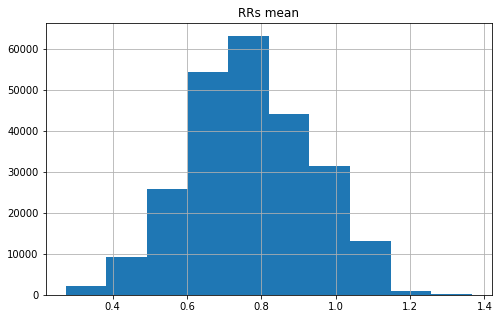

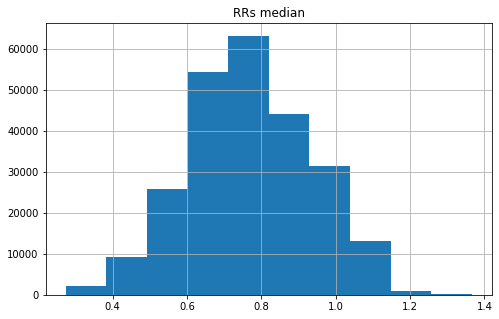

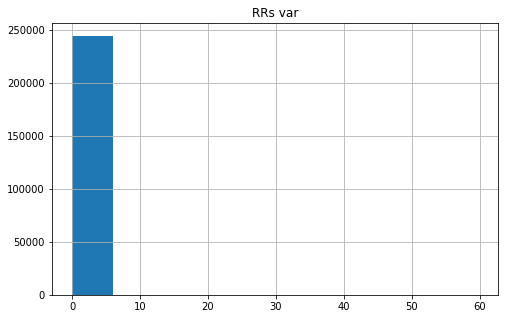

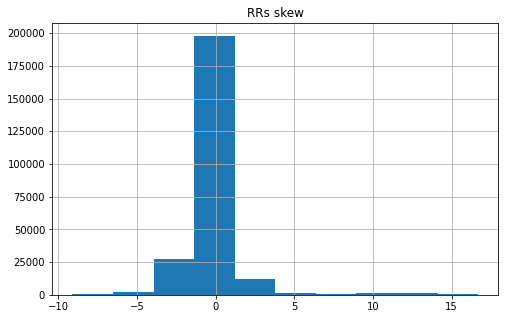

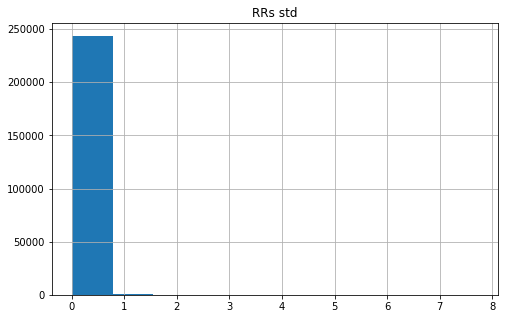

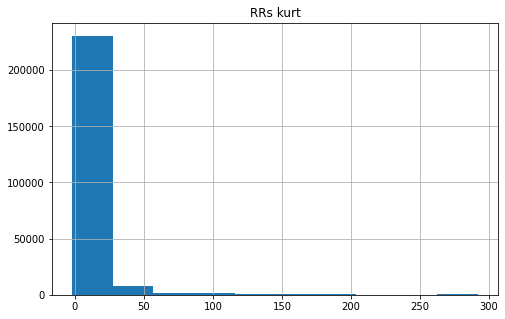

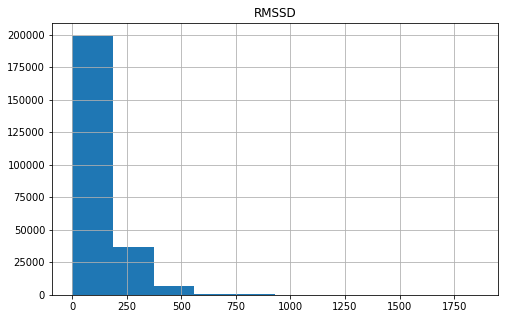

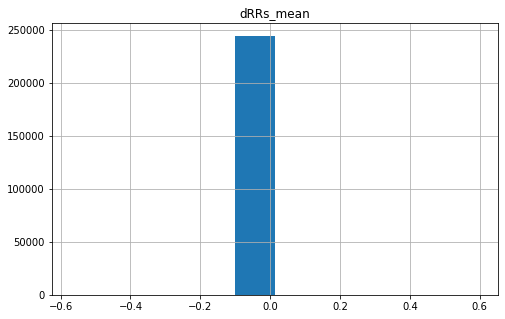

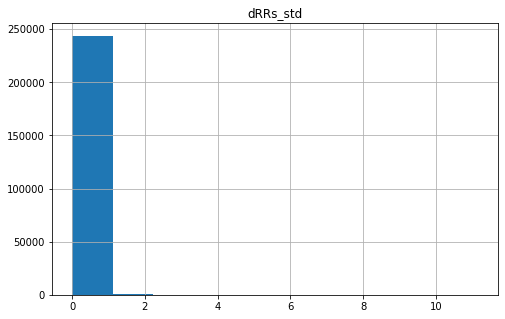

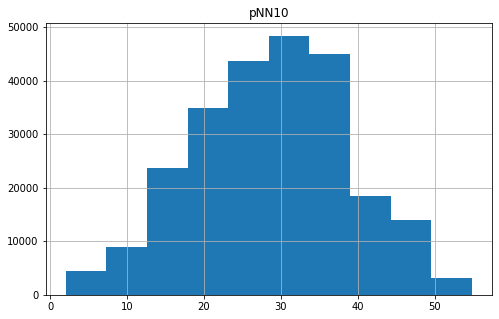

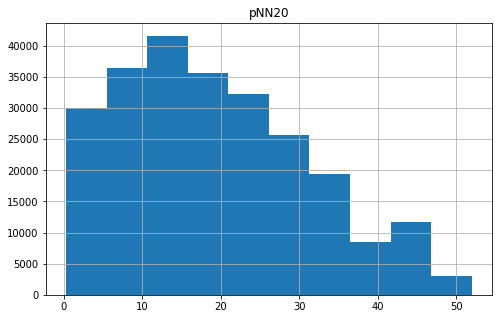

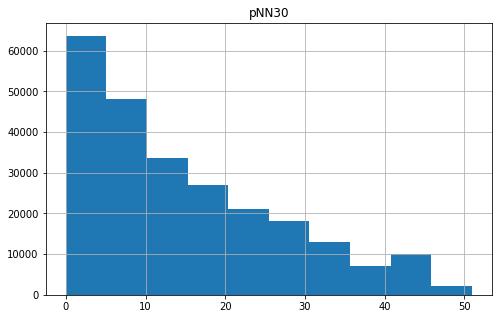

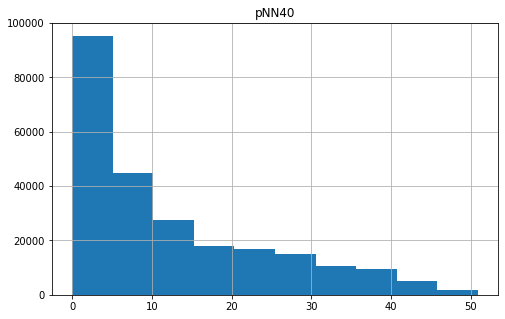

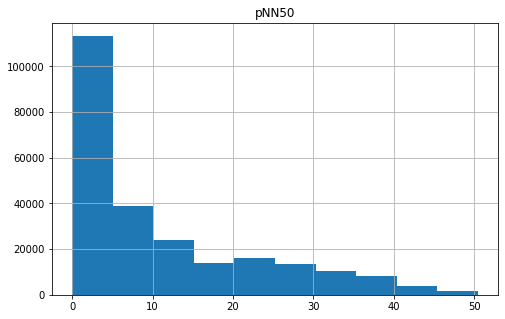

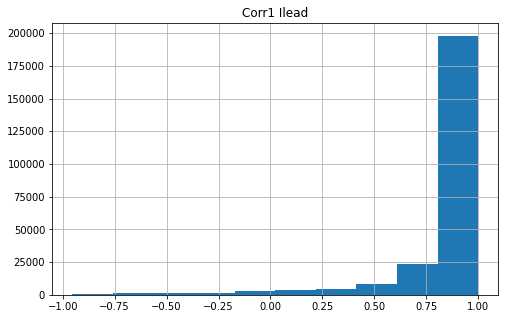

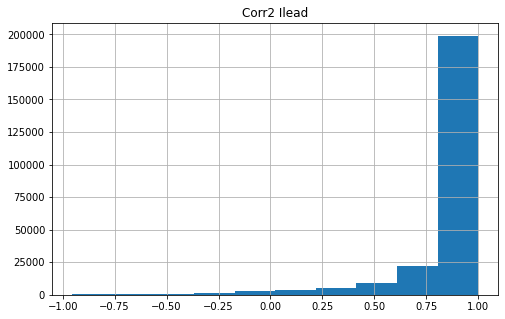

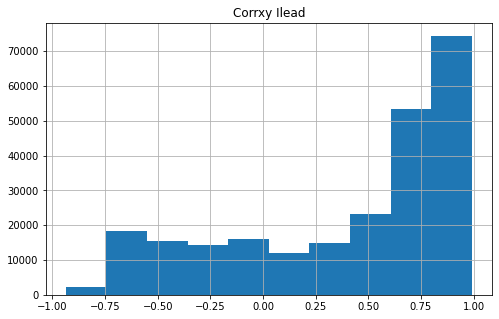

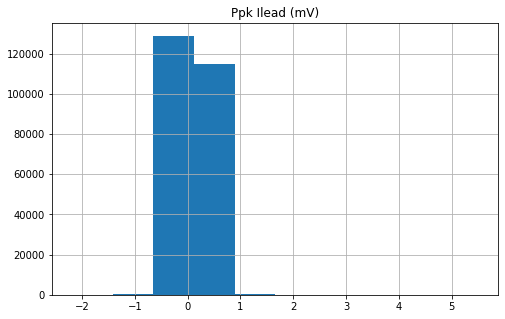

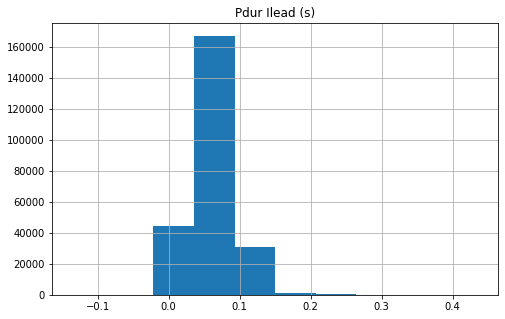

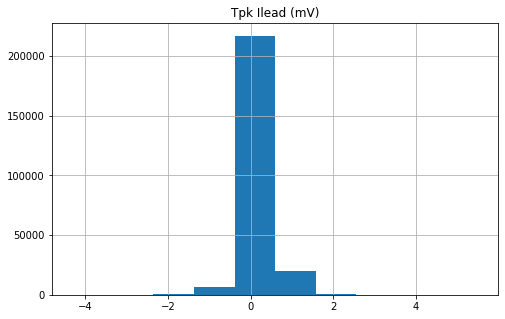

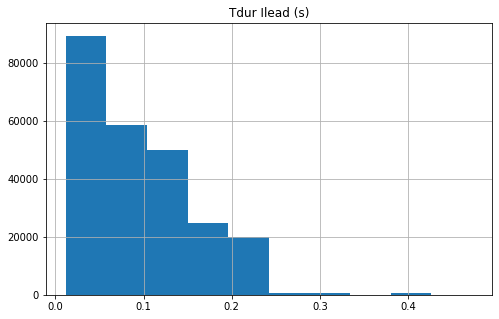

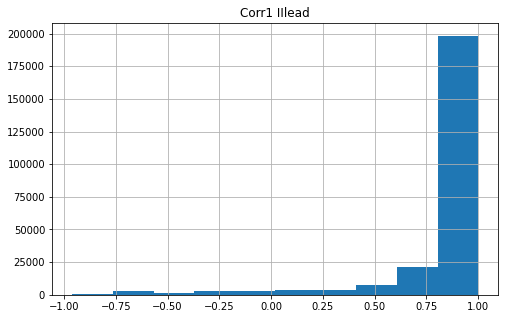

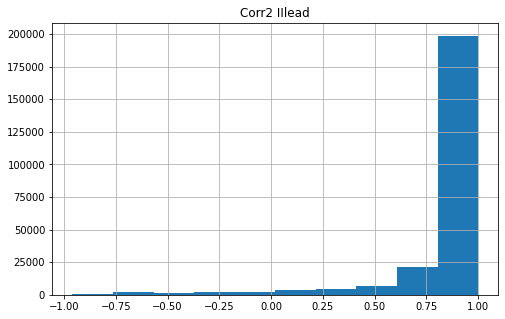

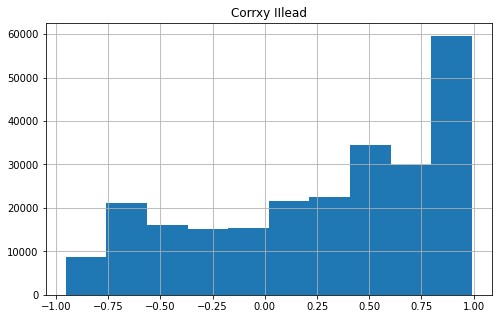

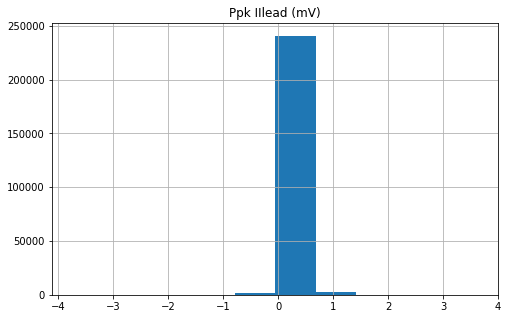

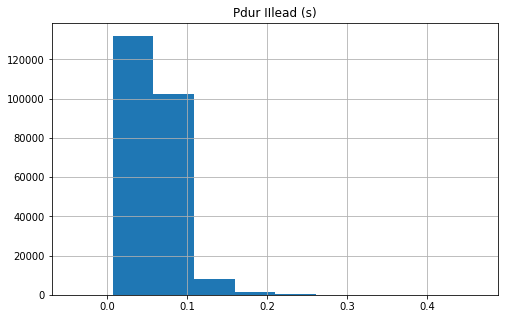

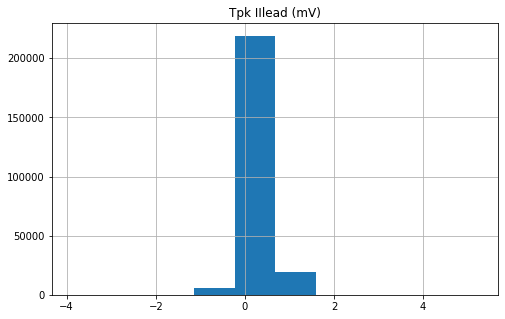

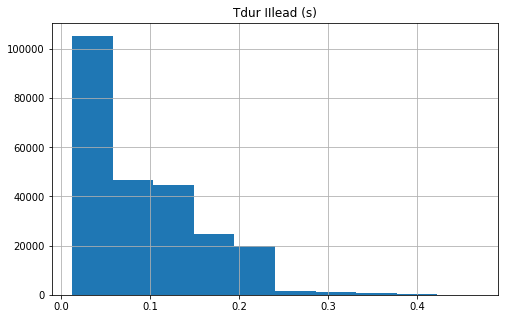

In [ ]:
for col in featuresML_all.loc[:, featuresML_all.columns != 'Target'].columns: 
      featuresML_all.loc[:, featuresML_all.columns != 'Target'].hist(column = col)

###TARGET DISTRIBUTION

Target
N    228704
S      8620
V      7012
dtype: int64


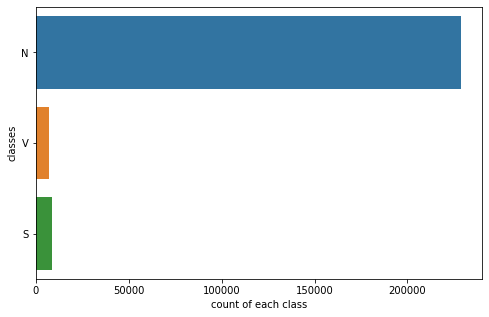

In [ ]:
print(featuresML_all.groupby('Target').size())

sns.countplot(y=featuresML_all.Target ,data=featuresML_all) #"target" is the name of the target column, change it accordingly to your dataset
plt.xlabel("count of each class")
plt.ylabel("classes")
plt.show()

##TRAIN/VALIDATION SPLIT

In order to evaluate the performance of our models, we test them against an hold-out dataset, called validation set. It is advisable the validation set to be as close as possible to the unseen data (test set) to have consistent results.
By performing stratification we maintain the same distribution of labels between training and validation to obtain a balanced division so that the classifier would not be biased, so with more generalization capability.

In [ ]:
trainfeatures_ML, valfeatures_ML, trainlabels_ML, vallabels_ML = train_test_split(featuresML_all.loc[:, featuresML_all.columns != 'Target'], np.array(onehot), test_size=0.2, random_state=SEED, shuffle=True, stratify=np.array(onehot))

print(trainfeatures_ML.shape, trainlabels_ML.shape, valfeatures_ML.shape, vallabels_ML.shape)

(195468, 28) (195468, 3) (48868, 28) (48868, 3)


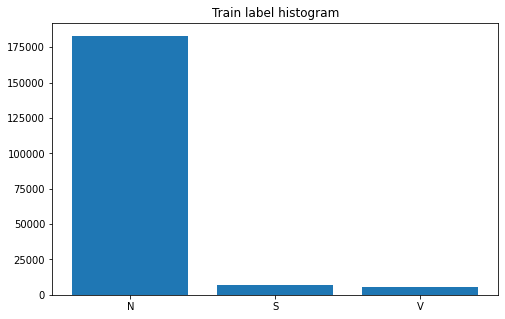

Labels distribution in the training set: {'N': 182962, 'S': 6896, 'V': 5610}


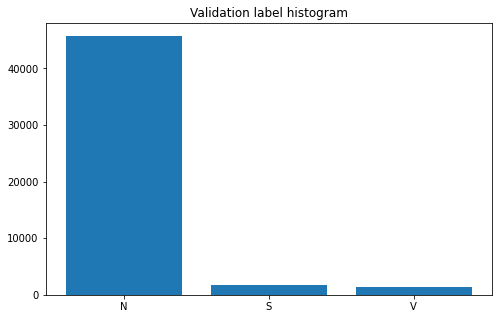

Labels distribution in the validation set: {'N': 45742, 'S': 1724, 'V': 1402}


In [ ]:
unique = np.unique(trainlabels_ML.argmax(axis=1), return_counts=True, axis=0)
trainlabelsML_dict = dict(zip(['N', 'S', 'V'], unique[1]))
plt.bar(trainlabelsML_dict.keys(), trainlabelsML_dict.values())
plt.title('Train label histogram')
plt.show()
print('Labels distribution in the training set: %s' %trainlabelsML_dict)

unique = np.unique(vallabels_ML.argmax(axis=1), return_counts=True, axis=0)
vallabelsML_dict = dict(zip(['N', 'S', 'V'], unique[1]))
plt.bar(vallabelsML_dict.keys(), vallabelsML_dict.values())
plt.title('Validation label histogram')
plt.show()
print('Labels distribution in the validation set: %s' %vallabelsML_dict)

##DATA BALANCING

When available, the parameter class_weight = 'balanced' of sklearn will be used. When the class_weights = ‘balanced’, the model automatically assigns the class weights inversely proportional to their respective frequencies.

##FEATURE PRE-PROCESSING

###Outlier removal

Since the target distribution is highly unbalanced, removing the outliers would not be cautious since the less frequent classes may result as outliers to the algorithm.

###Feature Scaling

In order to have comparable values for the signals in input it is necessary to normalize them.

####Robust Scaler

Robust scaler: (score – median)/(p75 – p25)

This scaling technique has been preferred with respect to others being more robust, indeed, to the outliers.

In [ ]:
feature_list_i = trainfeatures_ML.columns.tolist()

transformer = RobustScaler().fit(trainfeatures_ML)
train_features_rs = transformer.transform(trainfeatures_ML)
train_features_rs = pd.DataFrame(data=train_features_rs, columns=feature_list_i)

val_features_rs = transformer.transform(valfeatures_ML)                           # adapt validation set
val_features_rs = pd.DataFrame(data=val_features_rs, columns=feature_list_i)

###Feature Selection

Feature selection is the process of reducing the number of input variables when developing a predictive model.
It is desirable to reduce the number of input variables to both reduce the computational cost of modeling and, in some cases, to improve the performances.

####Low variance

The variance threshold is a simple baseline approach to feature selection. It removes all features which variance doesn't meet some threshold. By default, it removes all zero-variance features, i.e., features that have the same value in all samples.

In [ ]:
train_features_rs.var()

RRs mean              0.480761
RRs median            0.480761
RRs var            4619.620378
RRs skew              3.124909
RRs std               4.126757
RRs kurt             12.710735
RMSSD                 0.721300
dRRs_mean            19.054656
dRRs_std              2.646633
pNN10                 0.498531
pNN20                 0.455028
pNN30                 0.465726
pNN40                 0.494678
pNN50                 0.541532
Corr1 Ilead           4.301451
Corr2 Ilead           4.048671
Corrxy Ilead          0.369632
Ppk Ilead (mV)        1.488801
Pdur Ilead (s)        0.540075
Tpk Ilead (mV)        1.076421
Tdur Ilead (s)        0.391509
Corr1 IIlead          6.193851
Corr2 IIlead          5.978849
Corrxy IIlead         0.332772
Ppk IIlead (mV)       1.522357
Pdur IIlead (s)       0.670772
Tpk IIlead (mV)       1.111517
Tdur IIlead (s)       0.395480
dtype: float64

In [ ]:
train_features = train_features_rs
train_labels = trainlabels_ML
val_features = val_features_rs

vt = VarianceThreshold(threshold=(0.05))                                         
train_features_var = vt.fit_transform(train_features)
mask = vt.get_support()

train_features = train_features.loc[:, mask]

print('Deleted features: ' + str(list(compress(feature_list_i, ~mask))))

Deleted features: []


####Correlation

Features with high correlation are more linearly dependent and hence have almost the same effect on the dependent variable. So, when two features have high correlation, we can drop one of the two features.

In [ ]:
def plot_correlationMatrix(correlation_matrix, features):
    f = plt.figure(figsize=(10, 8))
    plt.matshow(correlation_matrix, fignum=f.number)
    plt.xticks(range(len(features)), features, fontsize=10, rotation=90)
    plt.yticks(range(len(features)), features, fontsize=10)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    return 

Deleted features: {'pNN40', 'RRs std', 'pNN10', 'RRs mean', 'pNN30'}


,RRs median,RRs var,RRs skew,RRs kurt,RMSSD,dRRs_mean,dRRs_std,pNN20,pNN50,Corr1 Ilead,Corr2 Ilead,Corrxy Ilead,Ppk Ilead (mV),Pdur Ilead (s),Tpk Ilead (mV),Tdur Ilead (s),Corr1 IIlead,Corr2 IIlead,Corrxy IIlead,Ppk IIlead (mV),Pdur IIlead (s),Tpk IIlead (mV),Tdur IIlead (s)
0,-0.779661,-0.348624,0.908523,-0.052469,-0.548147,0.25,-0.552730,-0.410525,-0.329562,0.123411,0.337843,-0.269861,-0.314043,-0.1,-0.332234,-0.583333,0.160569,0.358047,-1.039643,0.288979,-0.250,-0.440512,-0.44
1,-0.898305,0.284404,0.636591,-0.078550,0.426319,-0.25,0.420344,0.811582,1.334377,-3.381235,-3.829777,-0.124291,2.464681,-0.4,1.202828,-0.500000,-3.611436,-2.103228,0.296296,14.946331,0.000,2.505007,-0.24
2,-0.067797,-0.321101,0.069280,6.410793,-0.172959,0.25,-0.178758,-0.271880,-0.318592,-0.397621,-0.210413,-0.895057,-0.197445,-0.3,-0.708728,0.000000,-0.017754,0.134575,-0.516660,0.064068,-0.500,-0.737759,-0.12
3,-0.067797,-0.449541,-0.615259,-0.039098,-0.522312,0.25,-0.526552,-0.146869,-0.318167,-1.450461,-2.690032,-0.519846,0.137880,0.4,-0.426725,-0.541667,-0.390989,-2.132671,-0.814109,0.300319,0.250,-0.749481,-0.12
4,-1.525424,-0.403670,0.279139,-0.202690,-0.583389,0.25,-0.588631,-0.901421,-0.342174,0.369281,0.170851,-0.282871,1.109624,-0.6,-0.086672,-0.250000,0.374106,0.200891,-0.654070,1.723343,-0.625,-0.846193,-0.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48863,-0.118644,5.064220,0.067455,-0.432654,2.475082,-3.00,2.468212,0.852807,1.638290,-5.335475,-6.511626,-0.986327,1.831609,1.6,3.034020,0.833333,-13.165675,-13.742434,-1.150423,1.162241,3.250,-3.655632,1.28
48864,-1.474576,-0.440367,0.282310,1.031704,-0.541273,0.25,-0.545999,-0.624028,-0.355487,-1.422761,-0.069405,-0.783022,0.949645,0.1,-0.178655,-0.375000,-2.220957,0.233513,-0.785066,1.859864,-0.250,-0.195471,-0.44
48865,-0.576271,-0.376147,0.842702,0.265646,-0.488197,-0.75,-0.493642,-0.864770,-0.326924,-0.236085,-0.496106,0.282847,0.714877,-0.5,-0.494725,-0.583333,-0.633399,-0.814059,-1.176820,1.153894,-0.375,-0.209833,-0.32
48866,0.644068,2.036697,5.986740,10.580620,0.776182,-0.00,0.771129,0.591845,0.508836,-0.097948,-2.203054,-1.343942,-0.747099,1.0,-0.004926,0.291667,-0.713197,-0.564312,-0.262973,0.171537,1.625,0.071504,0.72


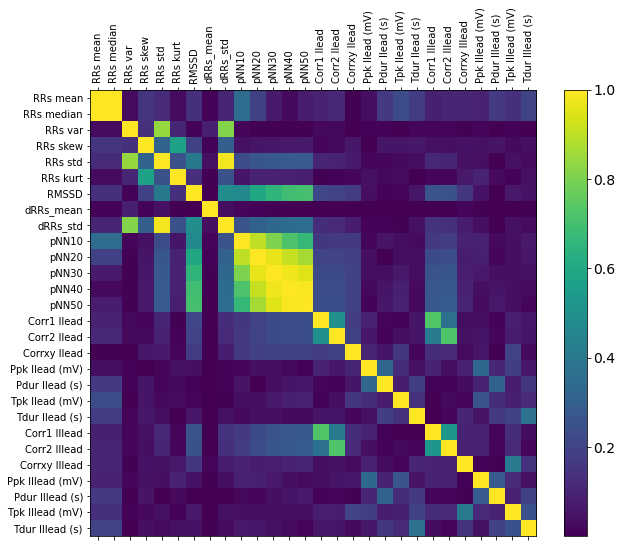

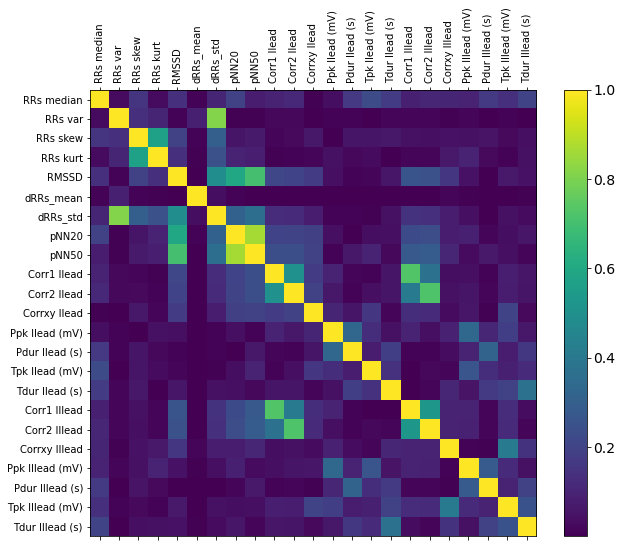

In [ ]:
cor_matrix = train_features.corr().abs()
plot_correlationMatrix(cor_matrix, feature_list_i)

correlated_features = set()
correlation_matrix = train_features.corr()
median_corr = (correlation_matrix.abs()).median(axis=0)

for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            if median_corr[i] < median_corr[j]:
                colname = correlation_matrix.columns[i]
            else:
                colname = correlation_matrix.columns[j]
            correlated_features.add(colname)           
train_features.drop(labels=correlated_features, axis=1, inplace=True)

print('Deleted features: ' + str(correlated_features))

cor_matrix = train_features.corr().abs()
feature_list = list(train_features.columns)
f2 = plot_correlationMatrix(cor_matrix, feature_list)

val_features = val_features[feature_list]                                         # adapt validation set
display(val_features)

####Recursive elimination (RFE)

Recursive feature elimination (RFE) is a feature selection method that fits a model and removes the weakest feature (or features) until the specified number of features is reached.

In [ ]:
def plot_recurrentFE(min_features_to_select, rfecv):
  plt.figure()
  plt.xlabel("Number of features selected")
  plt.ylabel("Cross validation score (accuracy)")
  plt.plot(range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select), rfecv.grid_scores_)
  plt.show()

Optimal number of features : 18


,ranking,selected
RRs median,1,True
RRs var,1,True
RRs skew,1,True
RRs kurt,1,True
RMSSD,1,True
dRRs_mean,6,False
dRRs_std,1,True
pNN20,1,True
pNN50,1,True
Corr1 Ilead,1,True


,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score
0,0.428081,0.000723,0.429101,0.427506,0.427635
1,0.472843,0.027022,0.495477,0.488191,0.434861
2,0.543021,0.005495,0.542517,0.536557,0.549988
3,0.618804,0.005532,0.617377,0.612856,0.626178
4,0.636440,0.003257,0.634929,0.633427,0.640964
5,0.643924,0.002234,0.642160,0.642536,0.647076
6,0.646443,0.001542,0.644686,0.646203,0.648440
7,0.695081,0.004414,0.698440,0.688845,0.697957
8,0.720645,0.000861,0.719933,0.720144,0.721856
9,0.731249,0.000471,0.731907,0.731010,0.730828


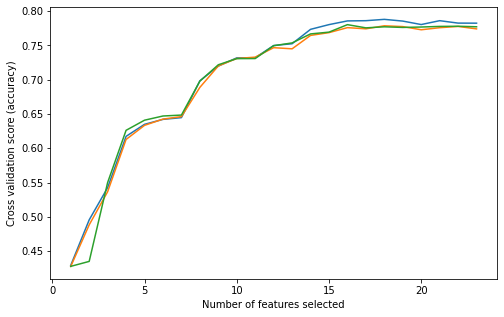

In [ ]:
rfc = RandomForestClassifier(class_weight='balanced', random_state=SEED)
min_features_to_select = 1

rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(3), scoring='balanced_accuracy', min_features_to_select=min_features_to_select)

rfecv.fit(train_features, train_labels.argmax(axis=1))

print("Optimal number of features : %d" % rfecv.n_features_)

train_features = train_features.iloc[:, rfecv.support_]                           # adapt training set
val_features = val_features.iloc[:, rfecv.support_]                               # adapt validation set

fs_results_2 = pd.DataFrame({'ranking': rfecv.ranking_, 'selected': rfecv.support_}, index = [rfecv.feature_names_in_])
display(fs_results_2)

fs_results_1 = pd.DataFrame(rfecv.cv_results_)
display(fs_results_1)

plot_recurrentFE(min_features_to_select, rfecv)

In [ ]:
trainfeatures_ML = train_features
trainlabels_ML = train_labels
valfeatures_ML = val_features
vallabels_ML = vallabels_ML

##MODEL DESIGN

In [ ]:
def testModel(train_features, train_labels, val_features, val_labels, clf):
  clf.fit(train_features, train_labels)                                           # fit the model
  val_predicted = clf.predict(val_features)                                       # predict validation labels
  plot_confusionMatrix(val_labels, val_predicted, clf)                            # plot confusion matrix
  print(classification_report(val_labels.argmax(axis=1), val_predicted.argmax(axis=1), target_names=['N', 'S', 'V']))   # display classification results

def plot_confusionMatrix(val_labels, val_predicted, clf):
  cm = confusion_matrix(val_labels.argmax(axis=1), val_predicted.argmax(axis=1))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['N', 'S', 'V'])
  disp.plot()
  plt.show()
  return 

###BASELINE MODEL SELECTION

We took in consideration distance-based methods, such as kNN, and rule-based ones, such as decision trees, to set a baseline for our classification task. However, due to the sensitivity to outliers of the former, we focused on decision trees.

####Decision Tree

The decision tree classifier creates the classification model by building a decision tree. Each node in the tree specifies a test on an attribute, each branch descending from that node corresponds to one of the possible values for that attribute.

In [ ]:
dt = DecisionTreeClassifier(criterion='gini', 
                            splitter='best', 
                            max_depth=None, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=None, 
                            random_state=SEED, 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            class_weight='balanced', 
                            ccp_alpha=0.0)

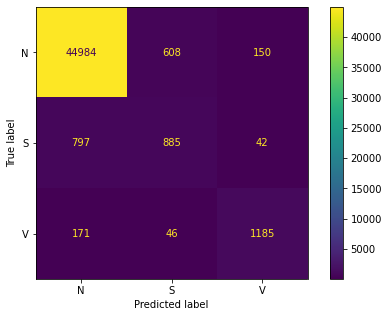

              precision    recall  f1-score   support

           N       0.98      0.98      0.98     45742
           S       0.58      0.51      0.54      1724
           V       0.86      0.85      0.85      1402

    accuracy                           0.96     48868
   macro avg       0.80      0.78      0.79     48868
weighted avg       0.96      0.96      0.96     48868



In [ ]:
testModel(trainfeatures_ML, trainlabels_ML, valfeatures_ML, vallabels_ML, dt)

We look now at boosting these perfomances by adopting a random forest.

####Random Forest

Random Forest is a supervised tree-based ensemble machine learning model trained with the "bagging" method. The concept behind bagging is that the combination of several weak simple classifiers can lead to high performance. Random Forest builds a strong classifier by adding together simple decision trees. A strong advantage of this methodology is its resistance toward over-fitting.

In [ ]:
forest = RandomForestClassifier(n_estimators=100,
                                criterion='gini',
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=None, 
                                random_state=SEED, 
                                verbose=0, 
                                warm_start=False, 
                                class_weight='balanced',
                                ccp_alpha=0.0, 
                                max_samples=None)

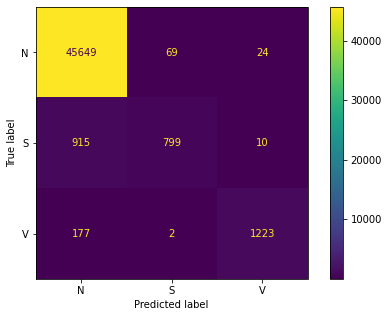

              precision    recall  f1-score   support

           N       0.98      1.00      0.99     45742
           S       0.92      0.46      0.62      1724
           V       0.97      0.87      0.92      1402

    accuracy                           0.98     48868
   macro avg       0.96      0.78      0.84     48868
weighted avg       0.97      0.98      0.97     48868



In [ ]:
testModel(trainfeatures_ML, trainlabels_ML, valfeatures_ML, vallabels_ML, forest)

###HYPERPARAMETER TUNING

After having defined a baseline model, it is now time to fine tune its parameters. Having the current settings resulted in satisfactory outcomes, we make use of a grid search algorithm to define what should be the optimal max_depth.

####Grid hyperparameter search

Grid search perfoms an exhaustive search over specified parameter values for an estimator. It uses a stratified K-Folds cross-validator (the folds are made by preserving the percentage of samples for each class).
The already set hyperparameters have already provided satisfactory results. With tuning we want now focus on the optimal depth of the tree, which remained still undefined previously.

In [ ]:
def hyperp_search(classifier, parameters):
  gs = GridSearchCV(classifier, parameters, cv = 3, scoring = 'f1_weighted', verbose = 0, n_jobs = -1, refit=True, error_score='raise')

  gs = gs.fit(trainfeatures_ML, trainlabels_ML)
  print("f1_train: %f using %s" % (gs.best_score_, gs.best_params_))
  
  global y_pred
  best_model = gs.best_estimator_
  y_pred = best_model.predict(valfeatures_ML)
  
  print("f1_test: ", f1_score(vallabels_ML, y_pred, average='weighted'))

  return gs.best_params_

In [ ]:
classifier = RandomForestClassifier(class_weight='balanced', random_state=SEED)
classifier.get_params().keys()
parameters = {'max_depth': [10, 100, 1000]}                                       # the maximum depth of the tree      

best_params_ = hyperp_search(classifier, parameters)

f1_train: 0.971122 using {'max_depth': 1000}
f1_test:  0.9732362845374432


In [ ]:
forestGS = RandomForestClassifier(**best_params_)

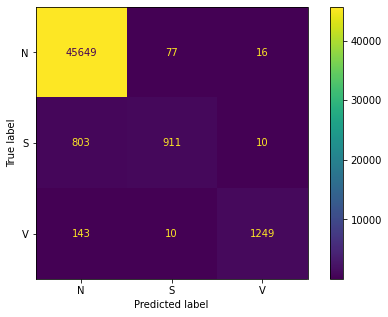

              precision    recall  f1-score   support

           N       0.98      1.00      0.99     45742
           S       0.91      0.53      0.67      1724
           V       0.98      0.89      0.93      1402

    accuracy                           0.98     48868
   macro avg       0.96      0.81      0.86     48868
weighted avg       0.98      0.98      0.98     48868



In [ ]:
testModel(trainfeatures_ML, trainlabels_ML, valfeatures_ML, vallabels_ML, forestGS)

Performances have slightly improved compared to the baseline model.

In [ ]:
filename = 'RandomForest'
filename_chosen = os.path.join(path, filename)
joblib.dump(forestGS, filename_chosen + '.joblib')

In [ ]:
forestGS = joblib.load("./RandomForest.joblib")

##MODEL TRAINING

We now train the optimized model on the entire available data.

###DATA PRE-PROCESSING

####Feature Scaling

#####Robust Scaler

In [ ]:
feature_list_i = featuresML_all.loc[:, featuresML_all.columns != 'Target'].columns.tolist()

transformer = RobustScaler().fit(featuresML_all.loc[:, featuresML_all.columns != 'Target'])
train_features_rs = transformer.transform(featuresML_all.loc[:, featuresML_all.columns != 'Target'])
train_features_rs = pd.DataFrame(data=train_features_rs, columns=feature_list_i)

In [ ]:
filename = 'transformer'
filename_chosen = os.path.join(path, filename)
joblib.dump(transformer, filename_chosen + '.joblib')

['/gdrive/MyDrive/AI_Assignment/transformer.joblib']

####Feature Selection

#####Low variance

In [ ]:
train_features_rs.var()

RRs mean              0.481703
RRs median            0.481703
RRs var            4655.590228
RRs skew              3.104705
RRs std               4.136469
RRs kurt             12.590661
RMSSD                 0.723684
dRRs_mean            29.767853
dRRs_std              2.638383
pNN10                 0.499113
pNN20                 0.455185
pNN30                 0.466521
pNN40                 0.495504
pNN50                 0.544976
Corr1 Ilead           4.323582
Corr2 Ilead           4.036638
Corrxy Ilead          0.369830
Ppk Ilead (mV)        1.533455
Pdur Ilead (s)        0.540721
Tpk Ilead (mV)        1.075440
Tdur Ilead (s)        0.392268
Corr1 IIlead          6.206477
Corr2 IIlead          5.993990
Corrxy IIlead         0.333093
Ppk IIlead (mV)       1.537306
Pdur IIlead (s)       0.670844
Tpk IIlead (mV)       1.113999
Tdur IIlead (s)       0.395358
dtype: float64

In [ ]:
train_features = train_features_rs
train_labels = np.array(onehot)

vt = VarianceThreshold(threshold=(0.05))                                          # eliminate constant features 
train_features_var = vt.fit_transform(train_features)
mask = vt.get_support()

train_features = train_features.loc[:, mask]

print('Deleted features: ' + str(list(compress(feature_list_i, ~mask))))

Deleted features: []


#####Correlation

In [ ]:
def plot_correlationMatrix(correlation_matrix, features):
    f = plt.figure(figsize=(10, 8))
    plt.matshow(correlation_matrix, fignum=f.number)
    plt.xticks(range(len(features)), features, fontsize=10, rotation=90)
    plt.yticks(range(len(features)), features, fontsize=10)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    return 

Deleted features: {'pNN40', 'RRs std', 'pNN10', 'RRs mean', 'pNN30'}


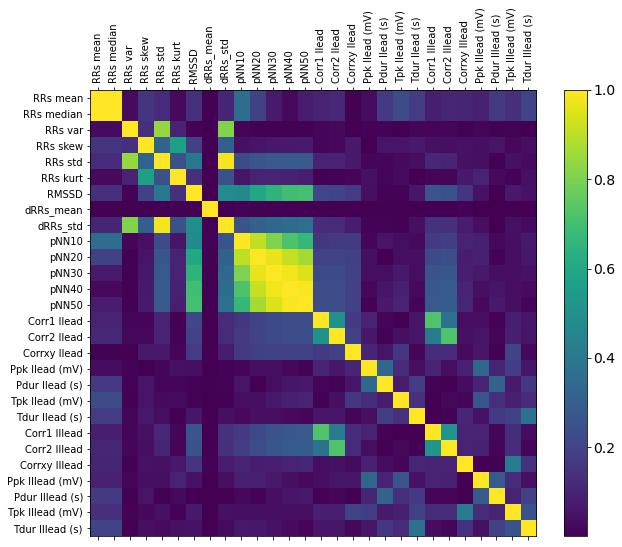

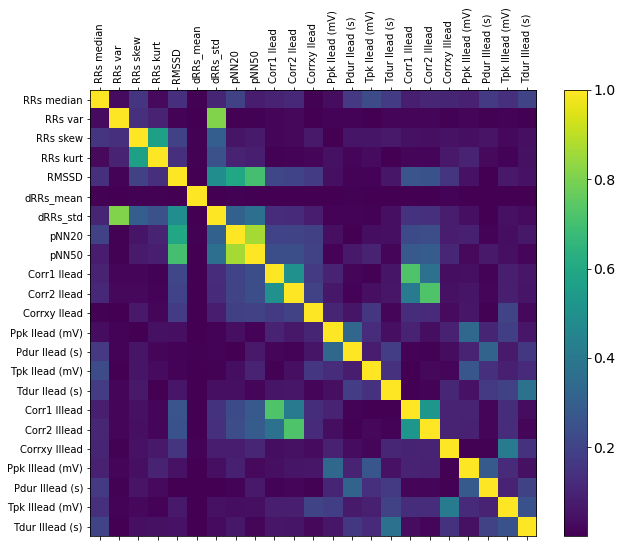

In [ ]:
cor_matrix = train_features.corr().abs()
plot_correlationMatrix(cor_matrix, feature_list_i)

correlated_features = set()
correlation_matrix = train_features.corr()
median_corr = (correlation_matrix.abs()).median(axis=0)

for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            if median_corr[i] < median_corr[j]:
                colname = correlation_matrix.columns[i]
            else:
                colname = correlation_matrix.columns[j]
            correlated_features.add(colname)           
train_features.drop(labels=correlated_features, axis=1, inplace=True)
 
print('Deleted features: ' + str(correlated_features))

cor_matrix = train_features.corr().abs()
feature_list = list(train_features.columns)
f2 = plot_correlationMatrix(cor_matrix, feature_list)

#####Recursive elimination (RFE)

In [ ]:
def plot_recurrentFE(min_features_to_select, rfecv):
  plt.figure()
  plt.xlabel("Number of features selected")
  plt.ylabel("Cross validation score (accuracy)")
  plt.plot(range(min_features_to_select,
                len(rfecv.grid_scores_) + min_features_to_select),
          rfecv.grid_scores_)
  plt.show()

Optimal number of features : 10


,ranking,selected
RRs median,6,False
RRs var,3,False
RRs skew,9,False
RRs kurt,7,False
RMSSD,1,True
dRRs_mean,14,False
dRRs_std,1,True
pNN20,4,False
pNN50,1,True
Corr1 Ilead,1,True


,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score
0,0.420043,0.033294,0.467055,0.398813,0.394262
1,0.448058,0.072767,0.535189,0.357072,0.451913
2,0.501062,0.095239,0.635454,0.441591,0.426140
3,0.519016,0.113401,0.679377,0.437086,0.440585
4,0.521710,0.114512,0.683556,0.435885,0.445689
5,0.521436,0.115789,0.684809,0.430125,0.449376
6,0.512476,0.106155,0.661327,0.421142,0.454959
7,0.518593,0.108146,0.670749,0.429110,0.455919
8,0.535901,0.101386,0.679154,0.469514,0.459036
9,0.537913,0.097932,0.675581,0.482181,0.455976


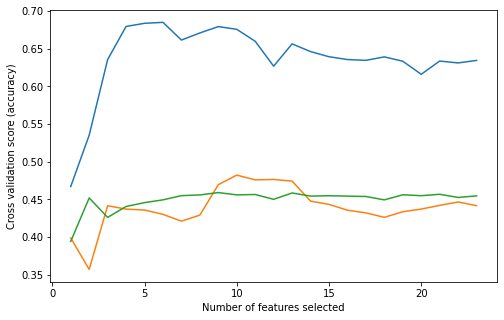

In [ ]:
rfc = RandomForestClassifier(class_weight='balanced', random_state=SEED)
min_features_to_select = 1

rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(3), scoring='balanced_accuracy', min_features_to_select=min_features_to_select)

rfecv.fit(train_features, np.array(onehot).argmax(axis=1))

print("Optimal number of features : %d" % rfecv.n_features_)

train_features = train_features.iloc[:, rfecv.support_]                           # adapt training set

fs_results_2 = pd.DataFrame({'ranking': rfecv.ranking_, 'selected': rfecv.support_}, index = [rfecv.feature_names_in_])
display(fs_results_2)

fs_results_1 = pd.DataFrame(rfecv.cv_results_)
display(fs_results_1)

plot_recurrentFE(min_features_to_select, rfecv)

In [ ]:
trainfeaturesML_all = train_features
trainlablesML_all = train_labels

###TRAINING

In [ ]:
forestGS_def = forestGS.fit(trainfeaturesML_all, trainlablesML_all)

In [ ]:
filename = 'RandomForest_def'
filename_chosen = os.path.join(path, filename)
joblib.dump(forestGS_def, filename_chosen + '.joblib')

In [ ]:
forestGS_def = joblib.load("./RandomForest_def.joblib")

#DEEP LEARNING

Through the deep learning approach we want to achieve an automatic interpretation of the ECG beats based on their morphology. Their relation over time will be instead taken into account by merging the previously computed features in a unique model which makes an ensemble of the two techniques.

##BEATS

Here we are considering the same beats as in the machine learning approach, where we discarded the first 90 seconds and the last 90 seconds beats of each signal to compute the HRV features. 

In [7]:
tpltHRVst_t = 90                                                                  # seconds before the R peak location
tpltHRVend_t = 90                                                                 # seconds after the R peak location
tpltHRVst_smp = tpltHRVst_t*fs                                                    # number of samples before the R peak location
tpltHRVend_smp = tpltHRVend_t*fs                                                  # number of samples after the R peak location

Here all the beats outside the range set by the template are substituted with the ECGs belonging to the first N beat.

In [9]:
ECGs = []
annts = []

ECG = 0                                                                           # ECGs are stored in the first column of the data matrix
Ilead = 0                                                                         # I lead is stored in the first column of the ECGs
column = 1                                                                        # 2nd column of the tot_beats matrix
ECG_Ilead = 3                                                                     # beat shape - I lead is in the 4th column of the tot_beats matrix 2nd column
ECG_IIlead = 6                                                                    # beat shape - II lead is in the 7th column of the tot_beats matrix 2nd column
beat_rpk = 0                                                                      # beat R peak location is stored in the first column   
ann = 1                                                                           # beat annotation is stored in the second column

for patient in range(num_patients):
  for idxi, i in enumerate(tot_beats[patient][column]):
    if (i[beat_rpk]-tpltHRVst_smp)>0 and (i[beat_rpk]+tpltHRVend_smp)<len(dataupblr_filt[patient][ECG][Ilead]):
      row = np.array([ i[ECG_Ilead], i[ECG_IIlead] ]).T
      ECGs.append(row)
      annts.append(i[ann])
    else:
      k = next((idxk, k) for idxk, k in enumerate(tot_beats[patient][column]) if k[ann]=='N')[0]
      row = np.array([ tot_beats[patient][column][k][ECG_Ilead], tot_beats[patient][column][k][ECG_IIlead] ]).T
      ECGs.append(row)
      annts.append(tot_beats[patient][column][k][ann])

##ENCODING

Being the target not ordinal and made up of only three possible outcomes, one-hot encoding is preferred over label encoding.

In [10]:
codes = ['N','S','V']
num_classes = len(codes)

onehot=[]

for i in annts:
  if i == 'N':
    one_hot_label = [1, 0, 0]
  elif i =='S':
    one_hot_label = [0, 1, 0]
  elif i =='V':
    one_hot_label = [0, 0, 1]
  onehot.append(one_hot_label) 

##DATA INSPECTION

###TARGET DISTRIBUTION

In [11]:
annts = pd.DataFrame(annts, columns=['Target'])

Target
N    228704
S      8620
V      7012
dtype: int64


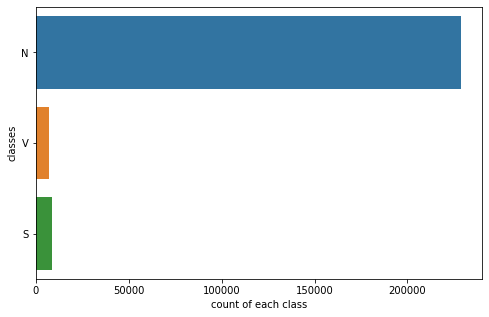

In [12]:
print(annts.groupby('Target').size())

sns.countplot(y=annts.Target ,data=annts) #"target" is the name of the target column, change it accordingly to your dataset
plt.xlabel("count of each class")
plt.ylabel("classes")
plt.show()

In [13]:
annts = annts.values.tolist()

##TRAIN/VALIDATION SPLIT

In [18]:
from sklearn.model_selection import train_test_split
trainfeatures_DL, valfeatures_DL, trainlabels_DL, vallabels_DL = train_test_split(np.array(ECGs), np.array(onehot), test_size=0.2, random_state=SEED,
                               shuffle=True, stratify=np.array(onehot))

print(trainfeatures_DL.shape, trainlabels_DL.shape, valfeatures_DL.shape, vallabels_DL.shape)

(195468, 176, 2) (195468, 3) (48868, 176, 2) (48868, 3)


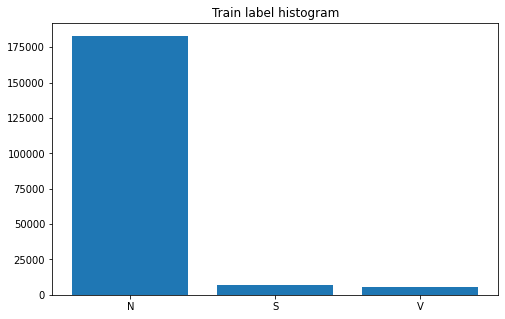

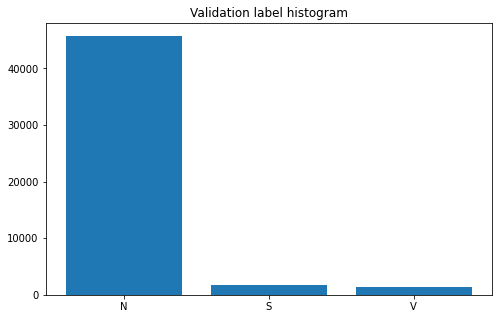

In [15]:
unique = np.unique(trainlabels_DL.argmax(axis=1), return_counts=True, axis=0)
trainlabelsDL_dict = dict(zip(['N', 'S', 'V'], unique[1]))
plt.bar(trainlabelsDL_dict.keys(), trainlabelsDL_dict.values())
plt.title('Train label histogram')
plt.show()

unique = np.unique(vallabels_DL.argmax(axis=1), return_counts=True, axis=0)
vallabelsDL_dict = dict(zip(['N', 'S', 'V'], unique[1]))
plt.bar(vallabelsDL_dict.keys(), vallabelsDL_dict.values())
plt.title('Validation label histogram')
plt.show()

##DATA BALANCING

The next algorithm assigns the class weights inversely proportional to the classes respective frequencies.

In [16]:
unique = np.unique(trainlabels_DL, return_counts=True, axis=0)
labels_dict = dict(zip([0, 1, 2], unique[1]))
print(labels_dict)

def get_class_weight(labels_dict):
    
    total = sum(labels_dict.values())
    max_num = max(labels_dict.values())
    mu = 1.0 / (total / max_num)
    class_weight = dict()
    for key, value in labels_dict.items():
        score = math.log(mu * total / float(value))
        class_weight[key] = score if score > 1.0 else 1.0
    return class_weight

class_weights = get_class_weight(labels_dict)
print(class_weights)

{0: 5610, 1: 6896, 2: 182962}
{0: 3.484727761471289, 1: 3.278336947644502, 2: 1.0}


##BEATS PRE-PROCESSING

###Beats Scaling

In order to have comparable values for the signals in input it is necessary to scale them. We apply the same scaling adopted for the machine learning approach.

####Robust Scaler

Robust scaler: (score – median)/(p75 – p25)

In [ ]:
trainfeatures_DL_median = np.nanmedian(trainfeatures_DL, axis=1)
trainfeatures_DL_median = np.median(trainfeatures_DL_median, axis=0)
trainfeatures_DL_75 = np.nanpercentile(trainfeatures_DL, 75, axis=1)
trainfeatures_DL_75 = np.percentile(trainfeatures_DL_75, 75, axis=0)
trainfeatures_DL_25 = np.nanpercentile(trainfeatures_DL, 25, axis=1)
trainfeatures_DL_25 = np.percentile(trainfeatures_DL_25, 25, axis=0)

trainfeatures_DL = (trainfeatures_DL - trainfeatures_DL_median)/(trainfeatures_DL_75-trainfeatures_DL_25)
valfeatures_DL = (valfeatures_DL - trainfeatures_DL_median)/(trainfeatures_DL_75-trainfeatures_DL_25)

##MODEL DESIGN

Two callbacks are defined in order to stop training when a monitored metric has stopped improving (early-stopping) and change the learning rate as the learning progresses (adaptive learning)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  min_delta=0,
                                                  patience=7,
                                                  verbose=0,
                                                  mode="auto", 
                                                  baseline=None,
                                                  restore_best_weights=False,
                                                  )

In [ ]:
adaptive_learning = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)

###BASELINE MODEL SELECTION

We will now evaluate the peroformances of different algorithms starting from the simplest one and growing up in complexity.

In [ ]:
input_shape = (176,2)                                                             # 176 is the number of samples per each beat, 2 is the number of channels (the two leads)
num_classes = 3

####FFNN

In [ ]:
def build_ffnn(input_shape):

    input_layer = tf.keras.layers.Input(shape=input_shape, name='Input')
    hidden_layer1 = tf.keras.layers.Dense(units=128, activation='relu', name='Hidden1')(input_layer)
    hidden_layer2 = tf.keras.layers.Dense(units=64, activation='relu', name='Hidden2')(hidden_layer1)
    flatten = tf.keras.layers.GlobalMaxPool1D()(hidden_layer2)
    output_layer = tf.keras.layers.Dense(units=num_classes, activation='softmax', name='Output')(flatten)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='FFNN')      # connect input and output through the Model class

    loss = 'categorical_crossentropy'
    optimizer = keras.optimizers.Adam()
    model.compile(loss=loss, optimizer=optimizer, metrics = [ 'accuracy', 'Precision', 'Recall' ])

    return model

In [ ]:
FFNN = build_ffnn(input_shape)
FFNN.summary()

Model: "FFNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 176, 2)]          0         
                                                                 
 Hidden1 (Dense)             (None, 176, 128)          384       
                                                                 
 Hidden2 (Dense)             (None, 176, 64)           8256      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 Output (Dense)              (None, 3)                 195       
                                                                 
Total params: 8,835
Trainable params: 8,835
Non-trainable params: 0
____________________________________________________________

In [ ]:
history_FFNN = FFNN.fit(
    x = trainfeatures_DL,
    y = trainlabels_DL, 
    validation_data=(valfeatures_DL, vallabels_DL),
    batch_size = 64,
    epochs = 10,
    class_weight = class_weights,
    callbacks = [ early_stopping, adaptive_learning ] 
).history

Epoch 1/10
2747/2747 [==============================] - 27s 10ms/step - loss: 0.5534 - accuracy: 0.9398 - precision: 0.9410 - recall: 0.9388 - val_loss: 0.2074 - val_accuracy: 0.9441 - val_precision: 0.9450 - val_recall: 0.9435 - lr: 0.0010
Epoch 2/10
2747/2747 [==============================] - 27s 10ms/step - loss: 0.5196 - accuracy: 0.9432 - precision: 0.9447 - recall: 0.9420 - val_loss: 0.2160 - val_accuracy: 0.9414 - val_precision: 0.9444 - val_recall: 0.9399 - lr: 0.0010
Epoch 3/10
2747/2747 [==============================] - 28s 10ms/step - loss: 0.5003 - accuracy: 0.9447 - precision: 0.9463 - recall: 0.9437 - val_loss: 0.1866 - val_accuracy: 0.9470 - val_precision: 0.9484 - val_recall: 0.9462 - lr: 0.0010
Epoch 4/10
2747/2747 [==============================] - 29s 11ms/step - loss: 0.4822 - accuracy: 0.9462 - precision: 0.9478 - recall: 0.9449 - val_loss: 0.1994 - val_accuracy: 0.9422 - val_precision: 0.9453 - val_recall: 0.9411 - lr: 0.0010
Epoch 5/10
2747/2747 [==============

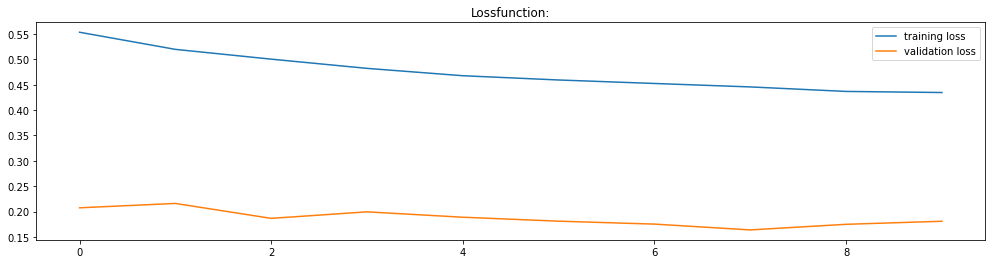

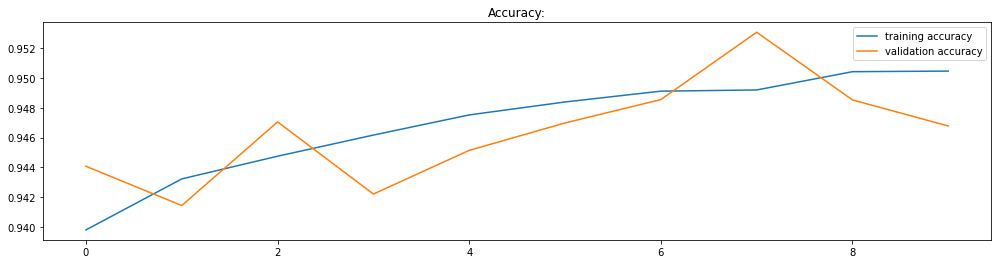

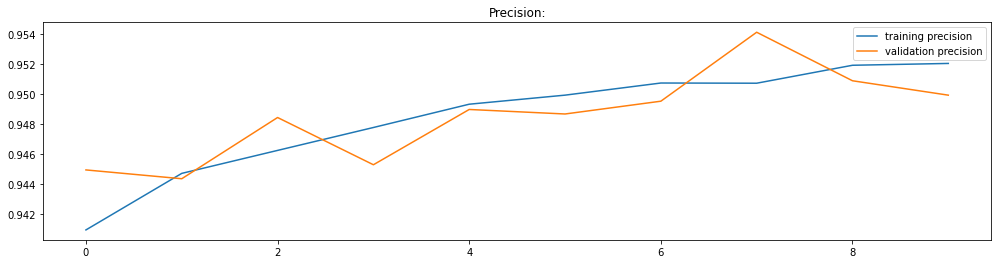

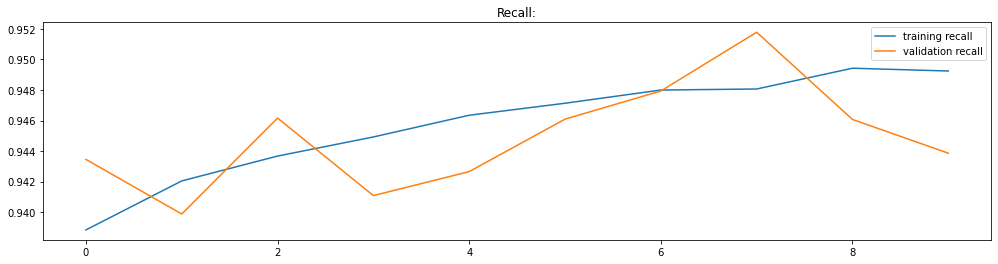

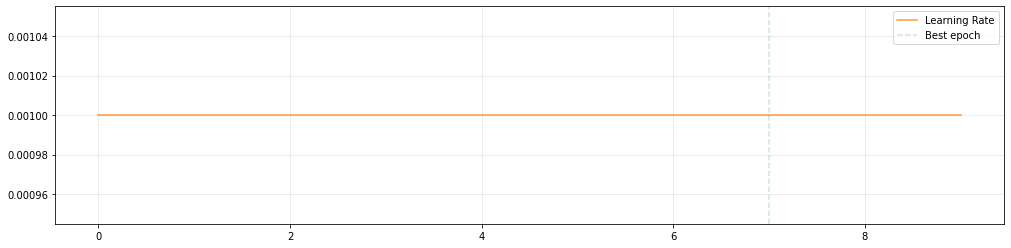

In [ ]:
best_epoch = np.argmin(history_FFNN['val_loss'])

plt.figure(figsize=(17,4))
plt.plot(history_FFNN['loss'], label="training loss")
plt.plot(history_FFNN['val_loss'], label="validation loss")
plt.title('Lossfunction:')
plt.legend()

plt.figure(figsize=(17,4))
plt.plot(history_FFNN['accuracy'], label="training accuracy")
plt.plot(history_FFNN['val_accuracy'], label="validation accuracy")
plt.title('Accuracy:')
plt.legend()

plt.figure(figsize=(17,4))
plt.plot(history_FFNN['precision'], label="training precision")
plt.plot(history_FFNN['val_precision'], label="validation precision")
plt.title('Precision:')
plt.legend()

plt.figure(figsize=(17,4))
plt.plot(history_FFNN['recall'], label="training recall")
plt.plot(history_FFNN['val_recall'], label="validation recall")
plt.title('Recall:')
plt.legend()

plt.figure(figsize=(17,4))
plt.plot(history_FFNN['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

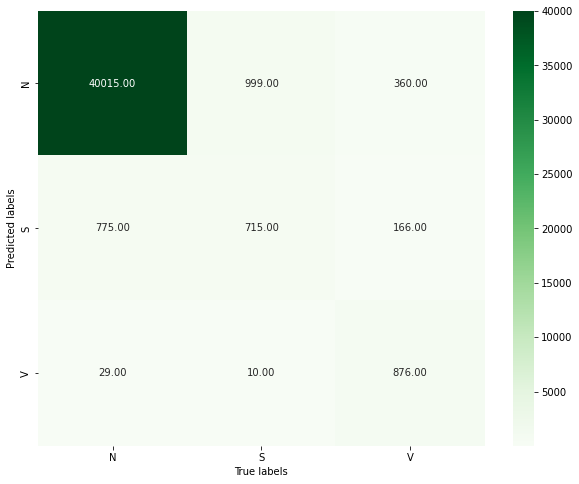

              precision    recall  f1-score   support

           N       0.97      0.98      0.97     40819
           S       0.43      0.41      0.42      1724
           V       0.96      0.62      0.76      1402

    accuracy                           0.95     43945
   macro avg       0.79      0.67      0.72     43945
weighted avg       0.95      0.95      0.95     43945



In [ ]:
pred = FFNN.predict(valfeatures_DL)
predicted_class = np.argmax(pred, axis=-1)
y_pred = np.zeros((predicted_class.size, predicted_class.max()+1))
y_pred[np.arange(predicted_class.size), predicted_class] = 1

cm = metrics.confusion_matrix(np.argmax(vallabels_DL,axis=1),np.argmax(pred,axis=1))
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(codes), yticklabels=list(codes), cmap="Greens", annot=True, fmt='.2f')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()
print(classification_report(vallabels_DL.argmax(axis=1), pred.argmax(axis=1), target_names=['N', 'S', 'V']))

In [ ]:
model_directory= '/gdrive/MyDrive/AI_Assignment/'
filename = 'FFNN'
filename_chosen = os.path.join(model_directory, filename)
FFNN.save(filename_chosen + '.h5')

####CNN

In [ ]:
CNN = keras.Sequential([
    keras.layers.Conv1D(filters=16, kernel_size=3, padding='same',
                        activation='relu', input_shape=input_shape),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv1D(filters=64, kernel_size=3,
                        padding='same', activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(num_classes, activation=tf.nn.softmax)
])

In [ ]:
CNN.compile(
    optimizer = keras.optimizers.Adam(),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy', 'Precision', 'Recall' ]
)

In [ ]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 176, 16)           112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 88, 16)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 88, 16)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 88, 64)            3136      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 44, 64)           0         
 1D)                                                             
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0

In [ ]:
history_CNN = CNN.fit(
    x = trainfeatures_DL,
    y = trainlabels_DL, 
    validation_data=(valfeatures_DL, vallabels_DL),
    batch_size = 64,
    epochs = 10,
    class_weight = class_weights,
    callbacks = [ early_stopping, adaptive_learning ] 
).history

Epoch 1/10
2747/2747 [==============================] - 38s 8ms/step - loss: 0.5738 - accuracy: 0.9430 - precision: 0.9445 - recall: 0.9415 - val_loss: 0.2014 - val_accuracy: 0.9404 - val_precision: 0.9420 - val_recall: 0.9389 - lr: 0.0010
Epoch 2/10
2747/2747 [==============================] - 17s 6ms/step - loss: 0.4696 - accuracy: 0.9485 - precision: 0.9507 - recall: 0.9466 - val_loss: 0.2009 - val_accuracy: 0.9372 - val_precision: 0.9391 - val_recall: 0.9365 - lr: 0.0010
Epoch 3/10
2747/2747 [==============================] - 17s 6ms/step - loss: 0.3992 - accuracy: 0.9536 - precision: 0.9558 - recall: 0.9519 - val_loss: 0.1416 - val_accuracy: 0.9512 - val_precision: 0.9532 - val_recall: 0.9496 - lr: 0.0010
Epoch 4/10
2747/2747 [==============================] - 17s 6ms/step - loss: 0.3522 - accuracy: 0.9586 - precision: 0.9608 - recall: 0.9572 - val_loss: 0.1473 - val_accuracy: 0.9483 - val_precision: 0.9509 - val_recall: 0.9474 - lr: 0.0010
Epoch 5/10
2747/2747 [==================

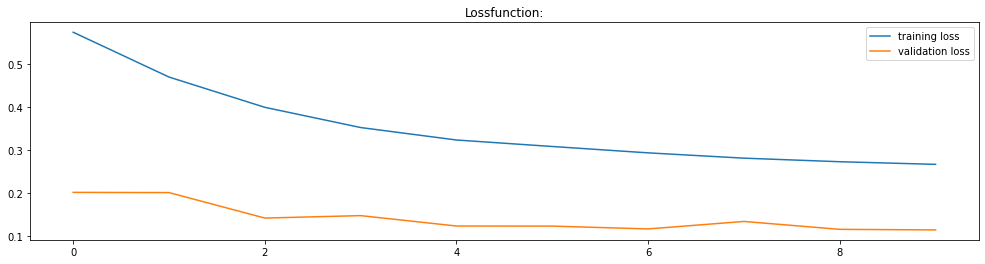

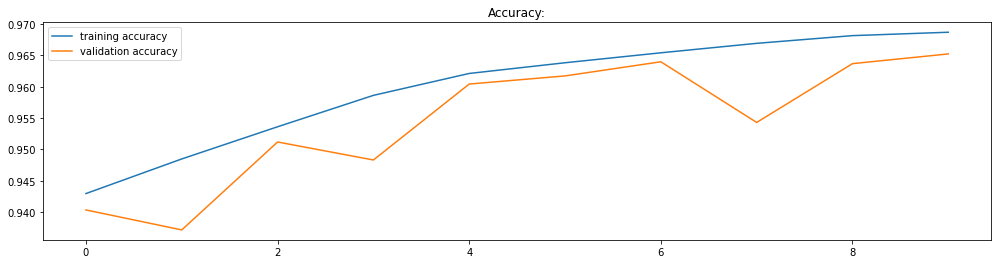

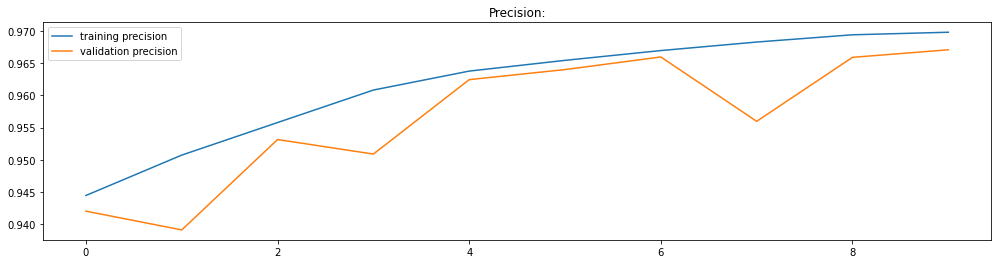

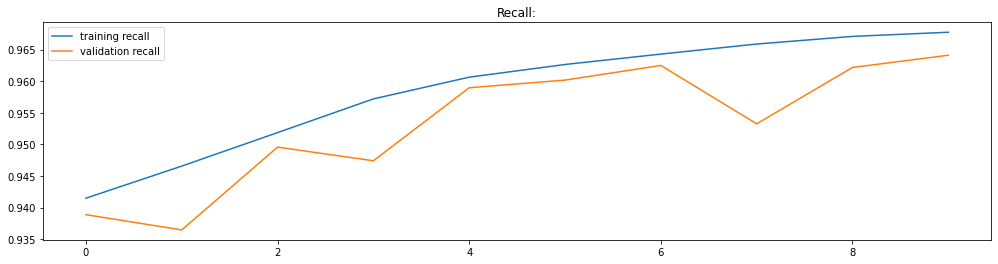

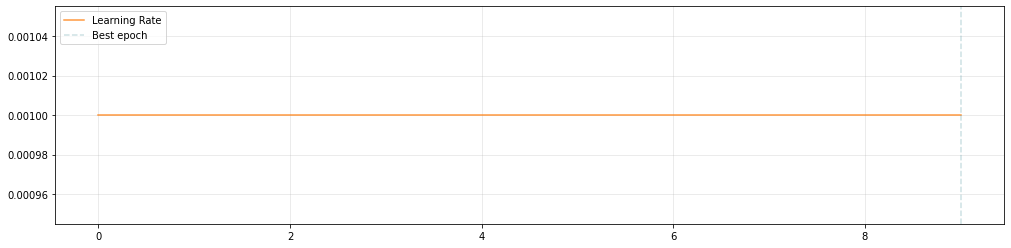

In [ ]:
best_epoch = np.argmin(history_CNN['val_loss'])

plt.figure(figsize=(17,4))
plt.plot(history_CNN['loss'], label="training loss")
plt.plot(history_CNN['val_loss'], label="validation loss")
plt.title('Lossfunction:')
plt.legend()

plt.figure(figsize=(17,4))
plt.plot(history_CNN['accuracy'], label="training accuracy")
plt.plot(history_CNN['val_accuracy'], label="validation accuracy")
plt.title('Accuracy:')
plt.legend()

plt.figure(figsize=(17,4))
plt.plot(history_CNN['precision'], label="training precision")
plt.plot(history_CNN['val_precision'], label="validation precision")
plt.title('Precision:')
plt.legend()

plt.figure(figsize=(17,4))
plt.plot(history_CNN['recall'], label="training recall")
plt.plot(history_CNN['val_recall'], label="validation recall")
plt.title('Recall:')
plt.legend()

plt.figure(figsize=(17,4))
plt.plot(history_CNN['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

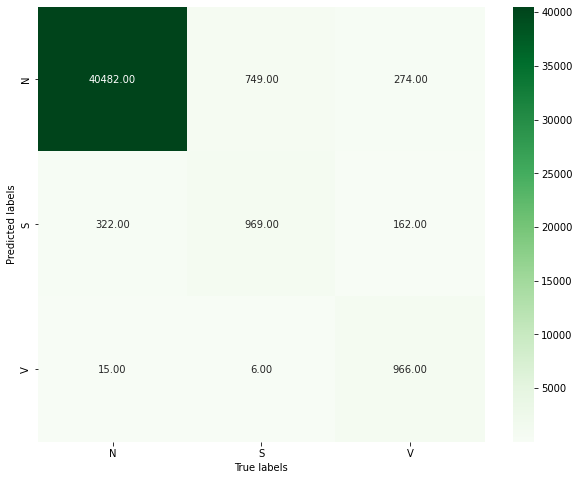

              precision    recall  f1-score   support

           N       0.98      0.99      0.98     40819
           S       0.67      0.56      0.61      1724
           V       0.98      0.69      0.81      1402

    accuracy                           0.97     43945
   macro avg       0.87      0.75      0.80     43945
weighted avg       0.96      0.97      0.96     43945



In [ ]:
pred = CNN.predict(valfeatures_DL)
predicted_class = np.argmax(pred, axis=-1)
y_pred = np.zeros((predicted_class.size, predicted_class.max()+1))
y_pred[np.arange(predicted_class.size), predicted_class] = 1

cm = metrics.confusion_matrix(np.argmax(vallabels_DL,axis=1),np.argmax(pred,axis=1))
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(codes), yticklabels=list(codes), cmap="Greens", annot=True, fmt='.2f')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()
print(classification_report(vallabels_DL.argmax(axis=1), pred.argmax(axis=1), target_names=['N', 'S', 'V']))   # display classification results

In [ ]:
model_directory= '/gdrive/MyDrive/AI_Assignment/'
filename = 'CNN'
filename_chosen = os.path.join(model_directory, filename)
CNN.save(filename_chosen + '.h5')

####VGG

In [ ]:
VGG = Sequential()

VGG.add(Conv1D(input_shape=input_shape,filters=64,kernel_size=3,padding="same", activation="relu"))
VGG.add(Conv1D(filters=64,kernel_size=3,padding="same", activation="relu"))
VGG.add(MaxPooling1D(pool_size=2,strides=2))
VGG.add(Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
VGG.add(Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
VGG.add(MaxPooling1D(pool_size=2,strides=2))
VGG.add(Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
VGG.add(Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
VGG.add(Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
VGG.add(MaxPooling1D(pool_size=2,strides=2))
VGG.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
VGG.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
VGG.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
VGG.add(MaxPooling1D(pool_size=2,strides=2))
VGG.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
VGG.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
VGG.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
VGG.add(MaxPooling1D(pool_size=2,strides=2))
VGG.add(keras.layers.GlobalMaxPooling1D())
VGG.add (Dense(512, activation='relu'))
VGG.add (Dropout(0.4))
VGG.add (Dense(num_classes,activation='softmax'))

In [ ]:
VGG.compile(
    optimizer = keras.optimizers.Adam(),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy', 'Precision', 'Recall']
)

In [ ]:
VGG.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 176, 64)           448       
                                                                 
 conv1d_3 (Conv1D)           (None, 176, 64)           12352     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 88, 64)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 88, 128)           24704     
                                                                 
 conv1d_5 (Conv1D)           (None, 88, 128)           49280     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 44, 128)          0         
 1D)                                                  

In [ ]:
history_VGG = VGG.fit(
    x = trainfeatures_DL,
    y = trainlabels_DL, 
    validation_data=(valfeatures_DL, vallabels_DL),
    batch_size = 64,
    epochs = 10,
    class_weight = class_weights,
    callbacks = [ early_stopping, adaptive_learning ] 
).history

Epoch 1/10
2747/2747 [==============================] - 91s 31ms/step - loss: 0.4002 - accuracy: 0.9520 - precision: 0.9578 - recall: 0.9471 - val_loss: 0.1138 - val_accuracy: 0.9630 - val_precision: 0.9684 - val_recall: 0.9590 - lr: 0.0010
Epoch 2/10
2747/2747 [==============================] - 76s 28ms/step - loss: 0.2661 - accuracy: 0.9681 - precision: 0.9707 - recall: 0.9660 - val_loss: 0.1005 - val_accuracy: 0.9706 - val_precision: 0.9734 - val_recall: 0.9684 - lr: 0.0010
Epoch 3/10
2747/2747 [==============================] - 74s 27ms/step - loss: 0.2346 - accuracy: 0.9725 - precision: 0.9750 - recall: 0.9704 - val_loss: 0.0782 - val_accuracy: 0.9768 - val_precision: 0.9784 - val_recall: 0.9756 - lr: 0.0010
Epoch 4/10
2747/2747 [==============================] - 75s 27ms/step - loss: 0.2150 - accuracy: 0.9748 - precision: 0.9769 - recall: 0.9729 - val_loss: 0.0722 - val_accuracy: 0.9777 - val_precision: 0.9792 - val_recall: 0.9758 - lr: 0.0010
Epoch 5/10
2747/2747 [==============

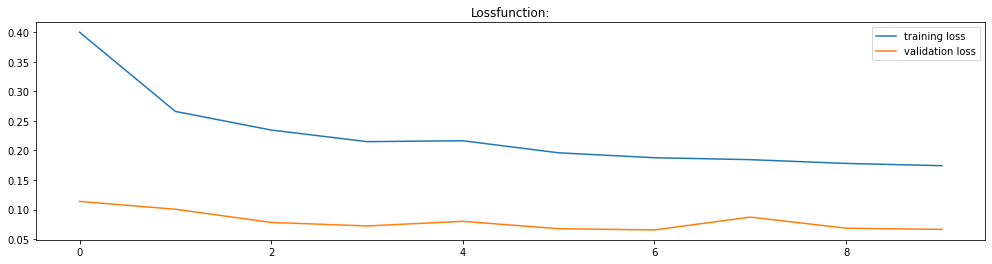

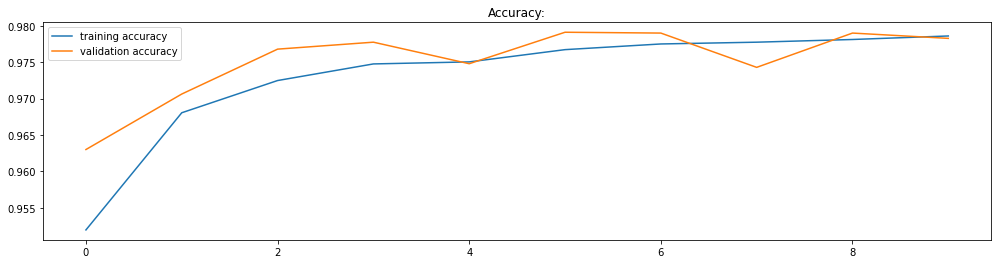

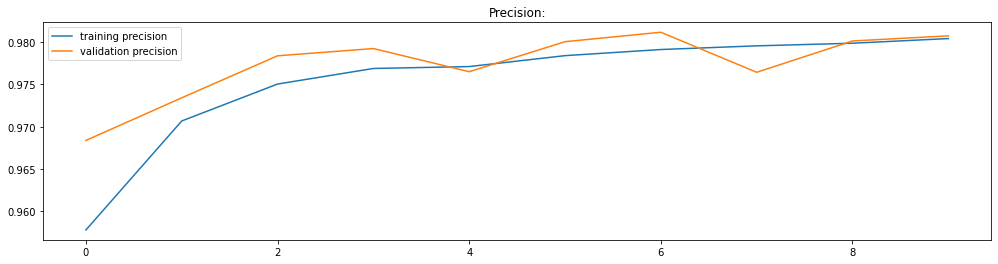

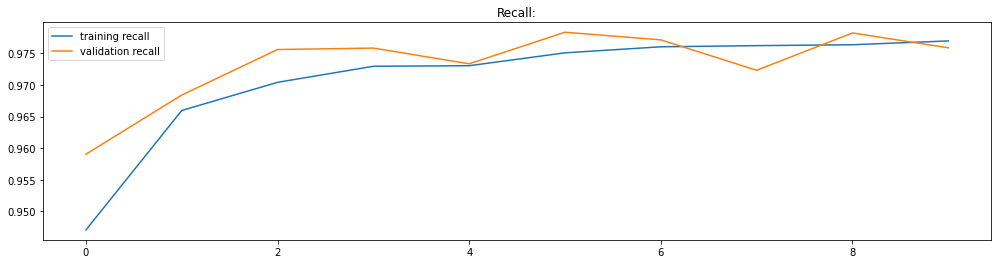

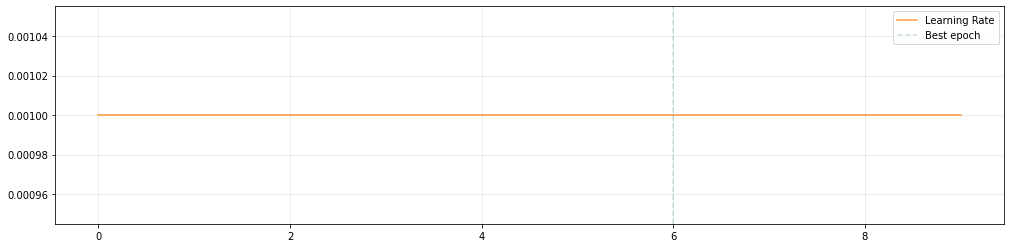

In [ ]:
best_epoch = np.argmin(history_VGG['val_loss'])

plt.figure(figsize=(17,4))
plt.plot(history_VGG['loss'], label="training loss")
plt.plot(history_VGG['val_loss'], label="validation loss")
plt.title('Lossfunction:')
plt.legend()

plt.figure(figsize=(17,4))
plt.plot(history_VGG['accuracy'], label="training accuracy")
plt.plot(history_VGG['val_accuracy'], label="validation accuracy")
plt.title('Accuracy:')
plt.legend()

plt.figure(figsize=(17,4))
plt.plot(history_VGG['precision'], label="training precision")
plt.plot(history_VGG['val_precision'], label="validation precision")
plt.title('Precision:')
plt.legend()

plt.figure(figsize=(17,4))
plt.plot(history_VGG['recall'], label="training recall")
plt.plot(history_VGG['val_recall'], label="validation recall")
plt.title('Recall:')
plt.legend()

plt.figure(figsize=(17,4))
plt.plot(history_VGG['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

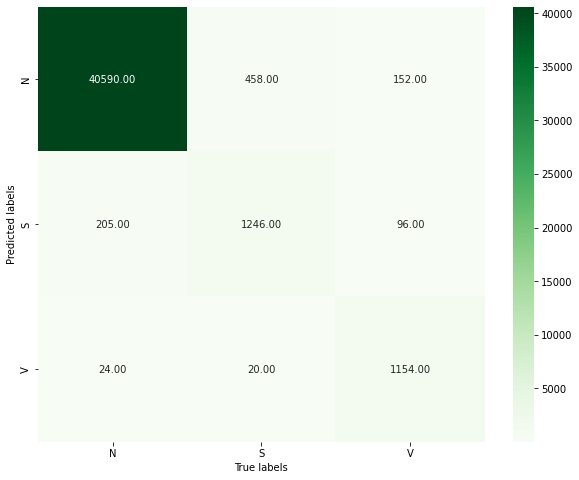

              precision    recall  f1-score   support

           N       0.99      0.99      0.99     40819
           S       0.81      0.72      0.76      1724
           V       0.96      0.82      0.89      1402

    accuracy                           0.98     43945
   macro avg       0.92      0.85      0.88     43945
weighted avg       0.98      0.98      0.98     43945



In [ ]:
pred = VGG.predict(valfeatures_DL)
predicted_class = np.argmax(pred, axis=-1)
y_pred = np.zeros((predicted_class.size, predicted_class.max()+1))
y_pred[np.arange(predicted_class.size), predicted_class] = 1

cm = metrics.confusion_matrix(np.argmax(vallabels_DL,axis=1),np.argmax(pred,axis=1))
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(codes), yticklabels=list(codes), cmap="Greens", annot=True, fmt='.2f')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()
print(classification_report(vallabels_DL.argmax(axis=1), pred.argmax(axis=1), target_names=['N', 'S', 'V']))   # display classification results

In [ ]:
model_directory= '/gdrive/MyDrive/AI_Assignment/'
filename = 'VGG'
filename_chosen = os.path.join(model_directory, filename)
VGG.save(filename_chosen + '.h5')

####ResNET

In [ ]:
def ResBs_Conv(block_input, num_filters): 
   
    # 0. Filter Block input and BatchNormalization
    block_input = Conv1D(num_filters, kernel_size=7, strides = 2,  padding = 'same')(block_input) 
    block_input = BatchNormalization()(block_input)

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)  
    dropout = Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = Activation('relu')(sum)
    
    return relu2 

def ResBs_Identity(block_input, num_filters): 

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)    
    dropout = Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = Activation('relu')(sum)
    
    return relu2 

def resnet(N=8, ch=2, win_len=176, classes=3): 
    ecg_input = Input(shape=(win_len, ch), name='ecg_signal') 

    ResNet = Conv1D(filters=64,kernel_size=15, padding = 'same')(ecg_input) 
    ResNet = BatchNormalization()(ResNet)
    ResNet = Activation('relu')(ResNet)
    ResNet = MaxPooling1D(pool_size=2, strides = 2)(ResNet)
    
    # B.5 ResBs (x8) blocks
    # First two ResNet blocks are identity blocks 
    ResNet = ResBs_Identity(ResNet, 64)
    ResNet = ResBs_Identity(ResNet, 64)

    filters = 64
    M= int((N -2 )/2)
    for i in range(M): 
        filters = filters*2
        # define N-th ResBs block
        ResNet = ResBs_Conv(ResNet, filters)
        ResNet = ResBs_Identity(ResNet, filters)
    
    ResNet = GlobalMaxPooling1D(name='gmp_layer')(ResNet)
    ResNet = Flatten()(ResNet) 

    # Sigmoid activation function on the last layer
    ResNet = Dense(classes, activation='softmax',  name='softmax_classifier')(ResNet)

    # Finally the model is composed by connecting inputs to outputs: 
    model = Model(inputs=[ecg_input],outputs=ResNet)
    return model

In [ ]:
from tensorflow.keras.layers import BatchNormalization
resNet_model = resnet(N=8, ch=2, win_len=176, classes=num_classes)

resNet_model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy', 'Precision', 'Recall' ]
)

In [ ]:
resNet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ecg_signal (InputLayer)        [(None, 176, 2)]     0           []                               
                                                                                                  
 conv1d_35 (Conv1D)             (None, 176, 64)      1984        ['ecg_signal[0][0]']             
                                                                                                  
 batch_normalization_20 (BatchN  (None, 176, 64)     256         ['conv1d_35[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_17 (Activation)     (None, 176, 64)      0           ['batch_normalization_20[0]

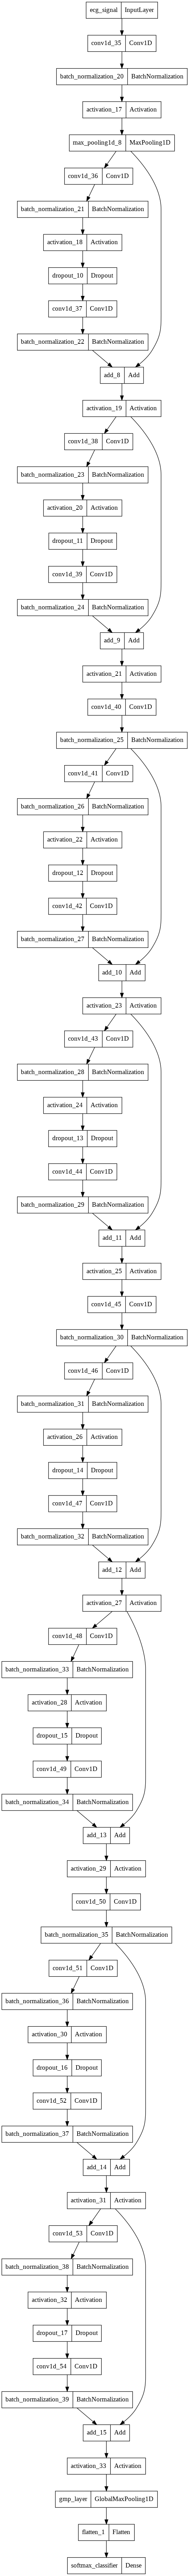

In [ ]:
tf.keras.utils.plot_model(
    resNet_model,
    to_file="resNet_model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

In [ ]:
history_rN = resNet_model.fit(
    x = trainfeatures_DL,
    y = trainlabels_DL, 
    validation_data=(valfeatures_DL, vallabels_DL),
    batch_size = 64,
    epochs = 10,
    class_weight = class_weights,
    callbacks = [ early_stopping, adaptive_learning ] 
).history

Epoch 1/10
2747/2747 [==============================] - 165s 55ms/step - loss: 0.3772 - accuracy: 0.9593 - precision: 0.9616 - recall: 0.9578 - val_loss: 0.0840 - val_accuracy: 0.9735 - val_precision: 0.9752 - val_recall: 0.9724 - lr: 0.0010
Epoch 2/10
2747/2747 [==============================] - 135s 49ms/step - loss: 0.2280 - accuracy: 0.9724 - precision: 0.9739 - recall: 0.9712 - val_loss: 0.0664 - val_accuracy: 0.9769 - val_precision: 0.9778 - val_recall: 0.9762 - lr: 0.0010
Epoch 3/10
2747/2747 [==============================] - 133s 48ms/step - loss: 0.1894 - accuracy: 0.9776 - precision: 0.9788 - recall: 0.9766 - val_loss: 0.1650 - val_accuracy: 0.9761 - val_precision: 0.9768 - val_recall: 0.9754 - lr: 0.0010
Epoch 4/10
2747/2747 [==============================] - 133s 48ms/step - loss: 0.1625 - accuracy: 0.9806 - precision: 0.9814 - recall: 0.9798 - val_loss: 0.0789 - val_accuracy: 0.9775 - val_precision: 0.9784 - val_recall: 0.9770 - lr: 0.0010
Epoch 5/10
2747/2747 [==========

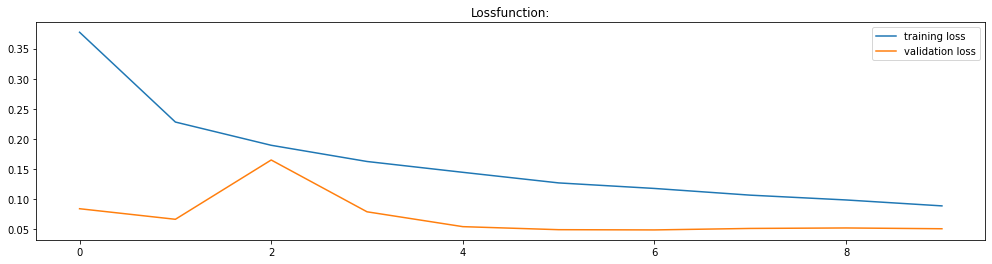

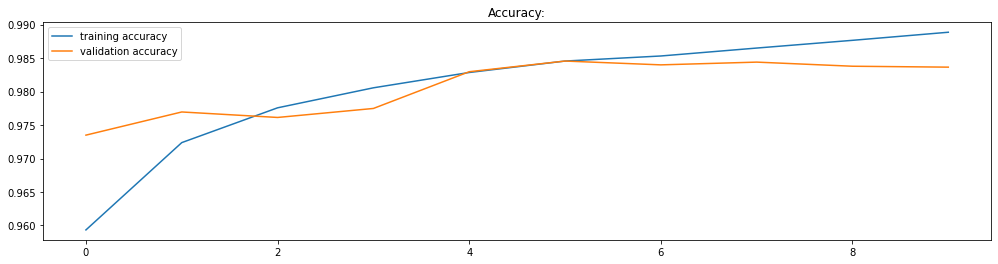

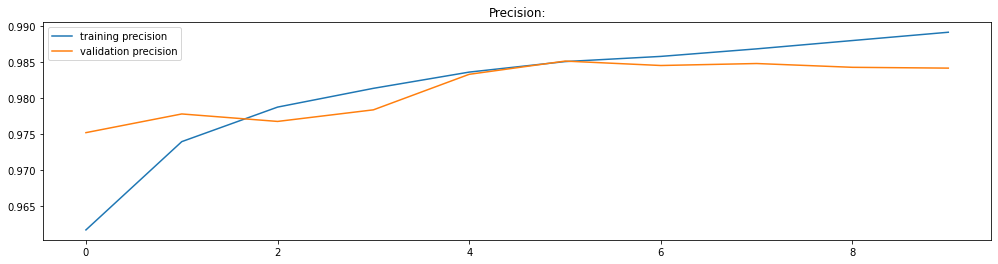

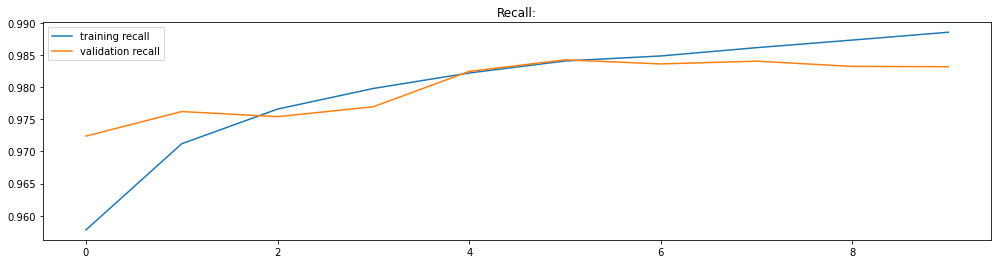

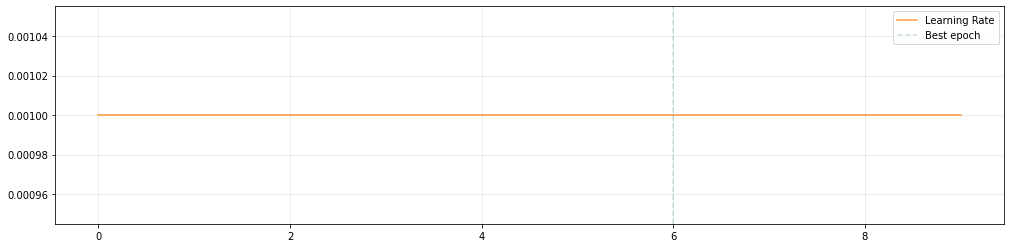

In [ ]:
best_epoch = np.argmin(history_rN['val_loss'])

plt.figure(figsize=(17,4))
plt.plot(history_rN['loss'], label="training loss")
plt.plot(history_rN['val_loss'], label="validation loss")
plt.title('Lossfunction:')
plt.legend()

plt.figure(figsize=(17,4))
plt.plot(history_rN['accuracy'], label="training accuracy")
plt.plot(history_rN['val_accuracy'], label="validation accuracy")
plt.title('Accuracy:')
plt.legend()

plt.figure(figsize=(17,4))
plt.plot(history_rN['precision'], label="training precision")
plt.plot(history_rN['val_precision'], label="validation precision")
plt.title('Precision:')
plt.legend()

plt.figure(figsize=(17,4))
plt.plot(history_rN['recall'], label="training recall")
plt.plot(history_rN['val_recall'], label="validation recall")
plt.title('Recall:')
plt.legend()

plt.figure(figsize=(17,4))
plt.plot(history_rN['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

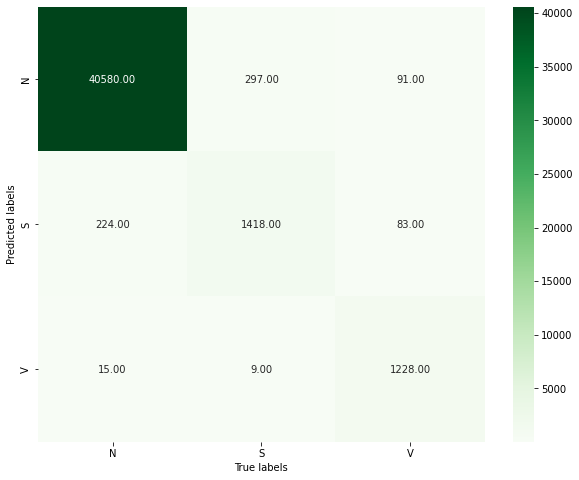

              precision    recall  f1-score   support

           N       0.99      0.99      0.99     40819
           S       0.82      0.82      0.82      1724
           V       0.98      0.88      0.93      1402

    accuracy                           0.98     43945
   macro avg       0.93      0.90      0.91     43945
weighted avg       0.98      0.98      0.98     43945



In [ ]:
pred = resNet_model.predict(valfeatures_DL)
predicted_class = np.argmax(pred, axis=-1)
y_pred = np.zeros((predicted_class.size, predicted_class.max()+1))
y_pred[np.arange(predicted_class.size), predicted_class] = 1

cm = metrics.confusion_matrix(np.argmax(vallabels_DL,axis=1),np.argmax(pred,axis=1))
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(codes), yticklabels=list(codes), cmap="Greens", annot=True, fmt='.2f')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()
print(classification_report(vallabels_DL.argmax(axis=1), pred.argmax(axis=1), target_names=['N', 'S', 'V']))   # display classification results

In [ ]:
model_directory= '/gdrive/MyDrive/AI_Assignment/'
filename = 'resNet'
filename_chosen = os.path.join(model_directory, filename)
resNet_model.save(filename_chosen + '.h5')

ResNET is performing better than the other models, so we look now at boosting its performances by adopting an hybrid approach.

####Wide ResNET

In classical machine learning approach, when performing hand-crafted feature extraction, we are explicitly providing the model what we want it to look at. 
However, in deep learning the user does not actually know exactly how the model is treating the data and what features it is focusing on.
The Wide ResNet proposes an embedded approach by merging the potential of both techniques.
Within this technique different options are available. We decided to train both the deep learning and the machine learning portion of the network in parallel.

In [ ]:
def ResBs_Conv(block_input, num_filters): 
   
    # 0. Filter Block input and BatchNormalization
    block_input = Conv1D(num_filters, kernel_size=7, strides = 2,  padding = 'same')(block_input) 
    block_input = BatchNormalization()(block_input)

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)  
    dropout = Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = Activation('relu')(sum)
    
    return relu2 

def ResBs_Identity(block_input, num_filters): 

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)    
    dropout = Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = Activation('relu')(sum)
    
    return relu2 

# model integrating deep + wide 
def resnet_deep_wide(N=8, ch=2, win_len=176, num_wide_features= 17, classes=num_classes): 
    # A. Wide features
    wide_input = Input(shape= (num_wide_features, ), name = 'wide_features')
    wide_branch = Dense(13, activation='relu')(wide_input)

    # B. ECG window input of shape (batch_size,  WINDOW_LEN, CHANNELS)
    ecg_input = Input(shape=(win_len, ch), name='ecg_signal') 

    ResNet = Conv1D(filters=64,kernel_size=15, padding = 'same')(ecg_input) 
    ResNet = BatchNormalization()(ResNet)
    ResNet = Activation('relu')(ResNet)
    ResNet = MaxPooling1D(pool_size=2, strides = 2)(ResNet)
    
    # B.5 ResBs (x8) blocks
    # The number of filters starts from 64 and doubles every two blocks
    
    # First two ResNet blocks are identity blocks 
    ResNet = ResBs_Identity(ResNet, 64)
    ResNet = ResBs_Identity(ResNet, 64)

    filters = 64
    M= int((N -2 )/2)
    for i in range(M): 
        filters = filters*2

        # define N-th ResBs block
        ResNet = ResBs_Conv(ResNet, filters)
        ResNet = ResBs_Identity(ResNet, filters)
    
    ResNet = GlobalMaxPooling1D(name='gmp_layer')(ResNet)
    ResNet = Flatten()(ResNet)

    shared_path = concatenate([ResNet, wide_branch], name='concat_layer')
    shared_path = Dense(classes, activation='softmax', name='softmax')(shared_path)
   
    # Finally the model is composed by connecting inputs to outputs: 
    model = Model(inputs=[ecg_input,  wide_input],outputs=shared_path)

    return model

In [ ]:
resNet_deep_wide_model = resnet_deep_wide(N=8, ch=2, win_len=176, num_wide_features=17, classes=num_classes)

resNet_deep_wide_model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy', 'Precision', 'Recall']
)

In [ ]:
resNet_deep_wide_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ecg_signal (InputLayer)        [(None, 176, 2)]     0           []                               
                                                                                                  
 conv1d_20 (Conv1D)             (None, 176, 64)      1984        ['ecg_signal[0][0]']             
                                                                                                  
 batch_normalization_20 (BatchN  (None, 176, 64)     256         ['conv1d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_17 (Activation)     (None, 176, 64)      0           ['batch_normalization_20[0]

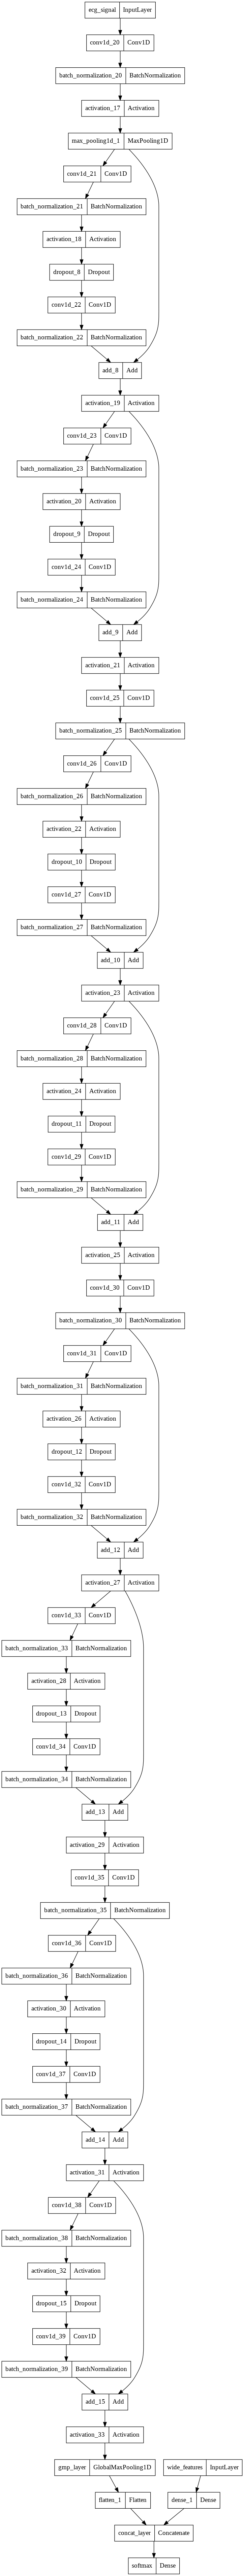

In [ ]:
tf.keras.utils.plot_model(
    resNet_deep_wide_model,
    to_file="resNet_model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

In [ ]:
train_features = {'ecg_signal':trainfeatures_DL, 'wide_features':trainfeatures_ML}
train_labels = {'softmax':trainlabels_ML}
val_features = {'ecg_signal':valfeatures_DL, 'wide_features':valfeatures_ML}
val_labels = {'softmax':vallabels_ML}

In [ ]:
history_wide = resNet_deep_wide_model.fit(
    x = train_features,
    y = train_labels, 
    validation_data=(val_features, val_labels),
    batch_size = 64,
    epochs = 10,
    #class_weight = class_weights,
    callbacks = [ early_stopping, adaptive_learning ] 
).history

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/10
2747/2747 [==============================] - ETA: 0s - loss: 0.1367 - accuracy: 0.9632 - precision: 0.9655 - recall: 0.9612

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


2747/2747 [==============================] - 601s 214ms/step - loss: 0.1367 - accuracy: 0.9632 - precision: 0.9655 - recall: 0.9612 - val_loss: 0.0854 - val_accuracy: 0.9727 - val_precision: 0.9746 - val_recall: 0.9714 - lr: 0.0010
Epoch 2/10
2747/2747 [==============================] - 547s 199ms/step - loss: 0.0785 - accuracy: 0.9745 - precision: 0.9756 - recall: 0.9734 - val_loss: 0.0705 - val_accuracy: 0.9771 - val_precision: 0.9782 - val_recall: 0.9763 - lr: 0.0010
Epoch 3/10
2747/2747 [==============================] - 541s 197ms/step - loss: 0.0674 - accuracy: 0.9784 - precision: 0.9794 - recall: 0.9776 - val_loss: 0.0615 - val_accuracy: 0.9807 - val_precision: 0.9813 - val_recall: 0.9803 - lr: 0.0010
Epoch 4/10
2747/2747 [==============================] - 547s 199ms/step - loss: 0.0561 - accuracy: 0.9816 - precision: 0.9822 - recall: 0.9809 - val_loss: 0.0709 - val_accuracy: 0.9799 - val_precision: 0.9802 - val_recall: 0.9795 - lr: 0.0010
Epoch 5/10
2747/2747 [=================

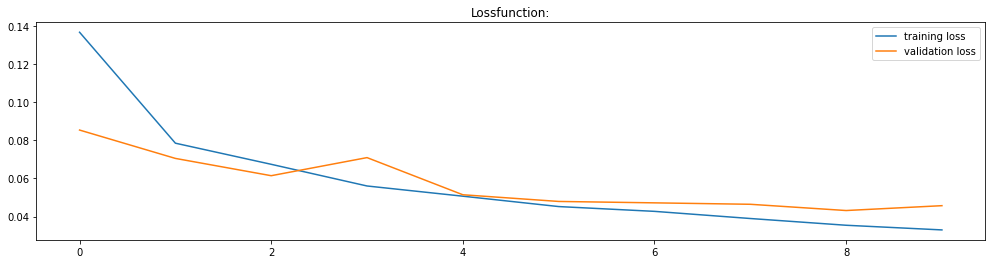

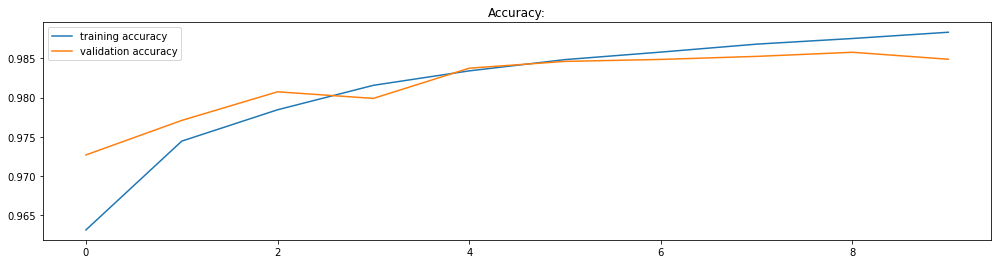

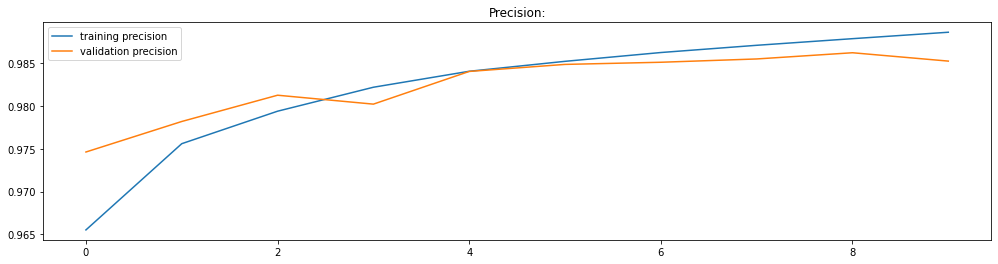

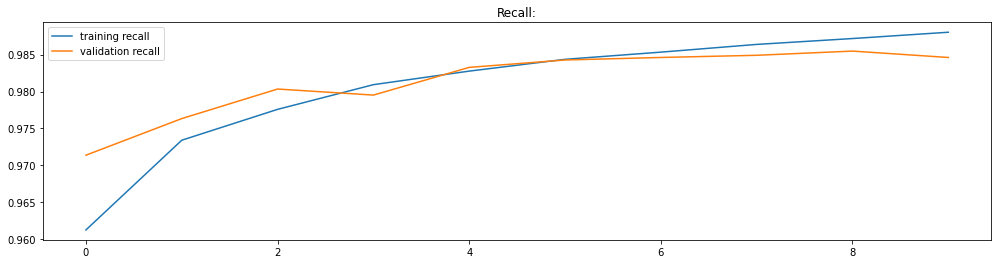

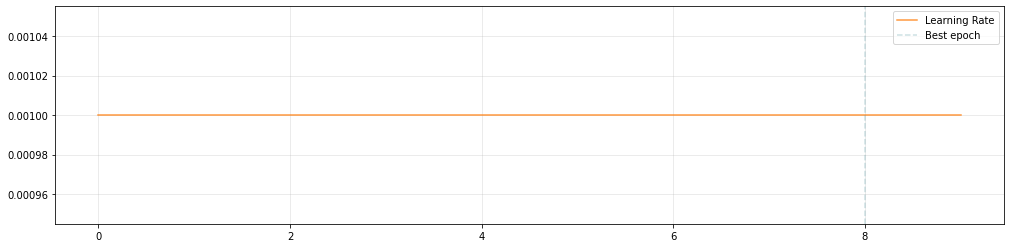

In [ ]:
best_epoch = np.argmin(history_wide['val_loss'])

plt.figure(figsize=(17,4))
plt.plot(history_wide['loss'], label="training loss")
plt.plot(history_wide['val_loss'], label="validation loss")
plt.title('Lossfunction:')
plt.legend()

plt.figure(figsize=(17,4))
plt.plot(history_wide['accuracy'], label="training accuracy")
plt.plot(history_wide['val_accuracy'], label="validation accuracy")
plt.title('Accuracy:')
plt.legend()

plt.figure(figsize=(17,4))
plt.plot(history_wide['precision'], label="training precision")
plt.plot(history_wide['val_precision'], label="validation precision")
plt.title('Precision:')
plt.legend()

plt.figure(figsize=(17,4))
plt.plot(history_wide['recall'], label="training recall")
plt.plot(history_wide['val_recall'], label="validation recall")
plt.title('Recall:')
plt.legend()

plt.figure(figsize=(17,4))
plt.plot(history_wide['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

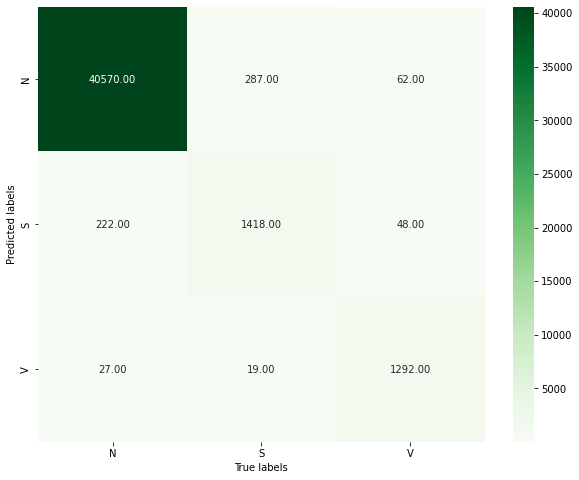

              precision    recall  f1-score   support

           N       0.99      0.99      0.99     40819
           S       0.84      0.82      0.83      1724
           V       0.97      0.92      0.94      1402

    accuracy                           0.98     43945
   macro avg       0.93      0.91      0.92     43945
weighted avg       0.98      0.98      0.98     43945



In [ ]:
pred = resNet_deep_wide_model.predict(val_features)
predicted_class = np.argmax(pred, axis=-1)
y_pred = np.zeros((predicted_class.size, predicted_class.max()+1))
y_pred[np.arange(predicted_class.size), predicted_class] = 1

cm = metrics.confusion_matrix(np.argmax(val_labels['softmax'],axis=1),np.argmax(pred,axis=1))
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(codes), yticklabels=list(codes), cmap="Greens", annot=True, fmt='.2f')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()
print(classification_report(vallabels_DL.argmax(axis=1), pred.argmax(axis=1), target_names=['N', 'S', 'V']))   # display classification results

In [ ]:
model_directory = '/gdrive/MyDrive/AI_Assignment/'
filename = 'resNet_deep_wide'
filename_chosen = os.path.join(model_directory, filename)
resNet_deep_wide_model.save(filename_chosen + '.h5')

Performances now are outweighing both the ResNET model and the ones obtained by adopting the machine learning approach only.

##MODEL TRAINING

We now train the network on the entire available data.

###DATA PRE-PROCESSING

####Feature Scaling

#####Robust Scaler

In [ ]:
trainfeatures_DL_median = np.nanmedian(np.array(ECGs), axis=1)
trainfeatures_DL_median = np.median(trainfeatures_DL_median, axis=0)
trainfeatures_DL_75 = np.nanpercentile(np.array(ECGs), 75, axis=1)
trainfeatures_DL_75 = np.percentile(trainfeatures_DL_75, 75, axis=0)
trainfeatures_DL_25 = np.nanpercentile(np.array(ECGs), 25, axis=1)
trainfeatures_DL_25 = np.percentile(trainfeatures_DL_25, 25, axis=0)

trainfeaturesDL_all = (np.array(ECGs) - trainfeatures_DL_median)/(trainfeatures_DL_75-trainfeatures_DL_25)

In [ ]:
np.save(path+'trainfeatures_DL_median', trainfeatures_DL_median, allow_pickle=True, fix_imports=True)
np.save(path+'trainfeatures_DL_75', trainfeatures_DL_75, allow_pickle=True, fix_imports=True)
np.save(path+'trainfeatures_DL_25', trainfeatures_DL_25, allow_pickle=True, fix_imports=True)

###TRAINING

The RFE algorithm has selected as optimal only 10 features when applied to the dataset in its entirety, so the network input with regards to this has been modified accordingly.

In [ ]:
from tensorflow.keras.layers import BatchNormalization

def ResBs_Conv(block_input, num_filters): 
   
    # 0. Filter Block input and BatchNormalization
    block_input = Conv1D(num_filters, kernel_size=7, strides = 2,  padding = 'same')(block_input) 
    block_input = BatchNormalization()(block_input)

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)  
    dropout = Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = Activation('relu')(sum)
    
    return relu2 

def ResBs_Identity(block_input, num_filters): 

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)    
    dropout = Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = Activation('relu')(sum)
    
    return relu2 

# model integrating deep + wide 
def resnet_deep_wide(N=8, ch=2, win_len=176, num_wide_features= 10, classes=num_classes): 
    # A. Wide features
    wide_input = Input(shape= (num_wide_features, ), name = 'wide_features')
    wide_branch = Dense(13, activation='relu')(wide_input)

    # B. ECG window input of shape (batch_size,  WINDOW_LEN, CHANNELS)
    ecg_input = Input(shape=(win_len, ch), name='ecg_signal') 

    ResNet = Conv1D(filters=64,kernel_size=15, padding = 'same')(ecg_input) 
    ResNet = BatchNormalization()(ResNet)
    ResNet = Activation('relu')(ResNet)
    ResNet = MaxPooling1D(pool_size=2, strides = 2)(ResNet)
    
    # B.5 ResBs (x8) blocks
    # The number of filters starts from 64 and doubles every two blocks
    
    # First two ResNet blocks are identity blocks 
    ResNet = ResBs_Identity(ResNet, 64)
    ResNet = ResBs_Identity(ResNet, 64)

    filters = 64
    M= int((N -2 )/2)
    for i in range(M): 
        filters = filters*2

        # define N-th ResBs block
        ResNet = ResBs_Conv(ResNet, filters)
        ResNet = ResBs_Identity(ResNet, filters)
    
    ResNet = GlobalMaxPooling1D(name='gmp_layer')(ResNet)
    ResNet = Flatten()(ResNet)

    shared_path = concatenate([ResNet, wide_branch], name='concat_layer')
    shared_path = Dense(classes, activation='softmax', name='softmax')(shared_path)
   
    # Finally the model is composed by connecting inputs to outputs: 
    model = Model(inputs=[ecg_input,  wide_input],outputs=shared_path)

    return model

In [ ]:
resNet_deep_wide_def_model = resnet_deep_wide(N=8, ch=2, win_len=176, num_wide_features=10, classes=num_classes)

resNet_deep_wide_def_model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy', 'Precision', 'Recall']
)

In [ ]:
resNet_deep_wide_def_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ecg_signal (InputLayer)        [(None, 176, 2)]     0           []                               
                                                                                                  
 conv1d_20 (Conv1D)             (None, 176, 64)      1984        ['ecg_signal[0][0]']             
                                                                                                  
 batch_normalization_20 (BatchN  (None, 176, 64)     256         ['conv1d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_17 (Activation)     (None, 176, 64)      0           ['batch_normalization_20[0][0

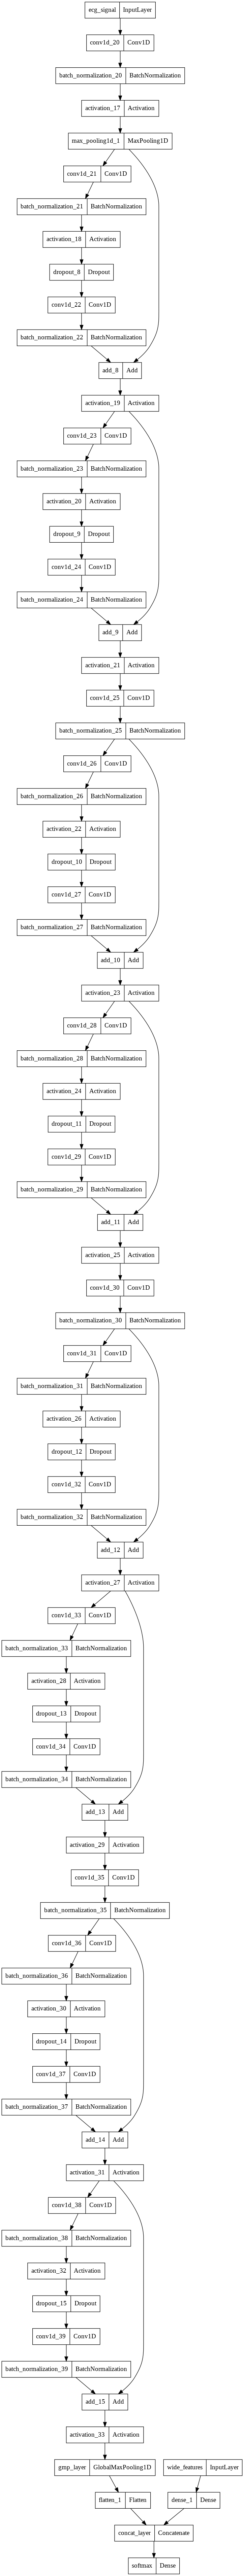

In [ ]:
tf.keras.utils.plot_model(
    resNet_deep_wide_def_model,
    to_file="resNet_model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

In [ ]:
trainfeatures_all = {'ecg_signal':trainfeaturesDL_all, 'wide_features':trainfeaturesML_all}
trainlabels_all = {'softmax':np.array(onehot)}

In [ ]:
history_wide_def = resNet_deep_wide_def_model.fit(
    x = trainfeatures_all,
    y = trainlabels_all, 
    batch_size = 64,
    epochs = 10,
    callbacks = [ early_stopping, adaptive_learning ] 
).history

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/10
3434/3434 [==============================] - 651s 186ms/step - loss: 0.1216 - accuracy: 0.9663 - precision: 0.9680 - recall: 0.9648 - lr: 0.0010
Epoch 2/10
3434/3434 [==============================] - 628s 183ms/step - loss: 0.0768 - accuracy: 0.9758 - precision: 0.9768 - recall: 0.9748 - lr: 0.0010
Epoch 3/10
3434/3434 [==============================] - 625s 182ms/step - loss: 0.0628 - accuracy: 0.9799 - precision: 0.9807 - recall: 0.9793 - lr: 0.0010
Epoch 4/10
3434/3434 [==============================] - 624s 182ms/step - loss: 0.0542 - accuracy: 0.9828 - precision: 0.9834 - recall: 0.9822 - lr: 0.0010
Epoch 5/10
3434/3434 [==============================] - 623s 181ms/step - loss: 0.0463 - accuracy: 0.9848 - precision: 0.9854 - recall: 0.9843 - lr: 0.0010
Epoch 6/10
3434/3434 [==============================] - 625s 182ms/step - loss: 0.0423 - accuracy: 0.9856 - precision: 0.9861 - recall: 0.9852 - lr: 0.0010
Epoch 7/10
3434/3434 [==============================] - 626s 182

In [ ]:
model_directory = '/gdrive/MyDrive/AI_Assignment/'
filename = 'resNet_deep_wide_def'
filename_chosen = os.path.join(model_directory, filename)
resNet_deep_wide_def_model.save(filename_chosen + '.h5')

In [ ]:
model_directory = '/gdrive/MyDrive/AI_Assignment/'
filename = 'resNet_deep_wide_def'
filename_chosen = os.path.join(model_directory, filename)
resNet_deep_wide_def_model = keras.models.load_model(filename_chosen + '.h5')